## <u>Case-Study: Music Generation Using LSTM</u>
This case study will deal with generating midi music using LSTM <br/>
Reference: https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5 <br/>
In this case study we will generate music using abc notation. ABC notation are a series of characters. By training the char-RNN we can generate new meaningful abc notation and convert it into midi format. Using following site we can convert, play and download the generated midi music https://abcjs.net/abcjs-editor.html <br/>
<u>Data-Source</u>: I have collected data using following two sources:

1. http://abc.sourceforge.net/NMD/
2. http://trillian.mit.edu/~jc/music/book/oneills/1850/X/ <br/>
I merged the abc notations of all the tunes into one text file which will act as input.

In [1]:
import os
import json
import argparse
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding

Using TensorFlow backend.


In [2]:
DATA_DIR = './data'
LOG_DIR = './logs'
MODEL_DIR = './model'

In [4]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

In [5]:
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

In [6]:
def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y

In [7]:
class TrainLogger(object):
    def __init__(self, file):
        self.file = os.path.join(LOG_DIR, file)
        self.epochs = 0
        with open(self.file, 'w') as f:
            f.write('epoch,loss,acc\n')

    def add_entry(self, loss, acc):
        self.epochs += 1
        s = '{},{},{}\n'.format(self.epochs, loss, acc)
        with open(self.file, 'a') as f:
            f.write(s)

In [8]:
def train(text, epochs, save_freq):

    # character to index and vice-versa mappings
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    with open(os.path.join(DATA_DIR, 'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    #model_architecture
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    #Train data generation
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32) #convert complete text into numerical indices

    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  

    log = TrainLogger('training_log.csv')

    for epoch in range(epochs):
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        
        losses, accs = [], []

        for i, (X, Y) in enumerate(read_batches(T, vocab_size)):
            
            #print(X);
            loss, acc = model.train_on_batch(X, Y)
            print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
            losses.append(loss)
            accs.append(acc)

        log.add_entry(np.average(losses), np.average(accs))

        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))

In [7]:
if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
train(open(os.path.join(DATA_DIR, "input.txt")).read(), 100, 10)

Number of unique characters: 86
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (16, 64, 512)             44032     
_________________________________________________________________
lstm_1 (LSTM)                (16, 64, 256)             787456    
_________________________________________________________________
dropout_1 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_2 (LSTM)                (16, 64, 256)             525312    
_________________________________________________________________
dropout_2 (Dropout)          (16, 64, 256)             0         
_______________________________________________________

Batch 99: loss = 2.756934642791748, acc = 0.2353515625
Batch 100: loss = 2.726947784423828, acc = 0.263671875
Batch 101: loss = 2.920135498046875, acc = 0.2177734375
Batch 102: loss = 2.9779295921325684, acc = 0.2001953125
Batch 103: loss = 2.8829305171966553, acc = 0.208984375
Batch 104: loss = 2.7745485305786133, acc = 0.234375
Batch 105: loss = 2.702662467956543, acc = 0.23828125
Batch 106: loss = 2.7654964923858643, acc = 0.234375
Batch 107: loss = 2.806772232055664, acc = 0.2294921875
Batch 108: loss = 2.701447010040283, acc = 0.2548828125
Batch 109: loss = 2.624694347381592, acc = 0.24609375
Batch 110: loss = 2.764573097229004, acc = 0.23046875
Batch 111: loss = 2.769519805908203, acc = 0.2646484375
Batch 112: loss = 2.746000051498413, acc = 0.2578125
Batch 113: loss = 2.721895694732666, acc = 0.24609375
Batch 114: loss = 2.8626604080200195, acc = 0.2216796875
Batch 115: loss = 2.802711248397827, acc = 0.2451171875
Batch 116: loss = 2.766936779022217, acc = 0.244140625
Batch 117:

Batch 123: loss = 1.943406581878662, acc = 0.4248046875
Batch 124: loss = 1.9015250205993652, acc = 0.43359375
Batch 125: loss = 1.8292503356933594, acc = 0.4599609375
Batch 126: loss = 2.02077579498291, acc = 0.40625

Epoch 3/100
Batch 1: loss = 2.4512686729431152, acc = 0.361328125
Batch 2: loss = 1.8895479440689087, acc = 0.4423828125
Batch 3: loss = 2.062023162841797, acc = 0.4208984375
Batch 4: loss = 1.849985957145691, acc = 0.45703125
Batch 5: loss = 1.981330156326294, acc = 0.416015625
Batch 6: loss = 2.057020664215088, acc = 0.4228515625
Batch 7: loss = 2.091796875, acc = 0.416015625
Batch 8: loss = 1.8745825290679932, acc = 0.462890625
Batch 9: loss = 1.9244987964630127, acc = 0.462890625
Batch 10: loss = 1.7572044134140015, acc = 0.4951171875
Batch 11: loss = 1.8536360263824463, acc = 0.46484375
Batch 12: loss = 2.021289825439453, acc = 0.4462890625
Batch 13: loss = 1.9408237934112549, acc = 0.4423828125
Batch 14: loss = 1.8511977195739746, acc = 0.4521484375
Batch 15: loss 

Batch 21: loss = 1.810774803161621, acc = 0.4716796875
Batch 22: loss = 1.6678733825683594, acc = 0.5078125
Batch 23: loss = 1.680580496788025, acc = 0.4912109375
Batch 24: loss = 1.7372902631759644, acc = 0.5
Batch 25: loss = 1.619311809539795, acc = 0.5234375
Batch 26: loss = 1.6386699676513672, acc = 0.5185546875
Batch 27: loss = 1.6378629207611084, acc = 0.5087890625
Batch 28: loss = 1.5826284885406494, acc = 0.525390625
Batch 29: loss = 1.5662949085235596, acc = 0.5517578125
Batch 30: loss = 1.625789999961853, acc = 0.5283203125
Batch 31: loss = 1.7198413610458374, acc = 0.49609375
Batch 32: loss = 1.9067401885986328, acc = 0.4482421875
Batch 33: loss = 1.7377053499221802, acc = 0.5009765625
Batch 34: loss = 1.6736335754394531, acc = 0.4970703125
Batch 35: loss = 1.675252914428711, acc = 0.4990234375
Batch 36: loss = 1.7875125408172607, acc = 0.4873046875
Batch 37: loss = 1.7324655055999756, acc = 0.525390625
Batch 38: loss = 1.709017276763916, acc = 0.4921875
Batch 39: loss = 1.6

Batch 45: loss = 1.3689513206481934, acc = 0.578125
Batch 46: loss = 1.4801874160766602, acc = 0.5400390625
Batch 47: loss = 1.4758317470550537, acc = 0.54296875
Batch 48: loss = 1.4119012355804443, acc = 0.5498046875
Batch 49: loss = 1.398828148841858, acc = 0.58984375
Batch 50: loss = 1.3892765045166016, acc = 0.5830078125
Batch 51: loss = 1.4830079078674316, acc = 0.53125
Batch 52: loss = 1.5573521852493286, acc = 0.5244140625
Batch 53: loss = 1.5584700107574463, acc = 0.5283203125
Batch 54: loss = 1.4746285676956177, acc = 0.576171875
Batch 55: loss = 1.5073997974395752, acc = 0.5556640625
Batch 56: loss = 1.4241011142730713, acc = 0.55859375
Batch 57: loss = 1.565049171447754, acc = 0.48828125
Batch 58: loss = 1.4944665431976318, acc = 0.5439453125
Batch 59: loss = 1.2775862216949463, acc = 0.61328125
Batch 60: loss = 1.4470069408416748, acc = 0.5322265625
Batch 61: loss = 1.5663197040557861, acc = 0.5244140625
Batch 62: loss = 1.6650689840316772, acc = 0.4677734375
Batch 63: loss

Batch 69: loss = 1.3191311359405518, acc = 0.5908203125
Batch 70: loss = 1.4747881889343262, acc = 0.525390625
Batch 71: loss = 1.3218501806259155, acc = 0.5810546875
Batch 72: loss = 1.310623049736023, acc = 0.5751953125
Batch 73: loss = 1.408919334411621, acc = 0.5498046875
Batch 74: loss = 1.3851948976516724, acc = 0.5380859375
Batch 75: loss = 1.4479775428771973, acc = 0.5390625
Batch 76: loss = 1.4602266550064087, acc = 0.5498046875
Batch 77: loss = 1.260224461555481, acc = 0.603515625
Batch 78: loss = 1.262890338897705, acc = 0.5888671875
Batch 79: loss = 1.151736855506897, acc = 0.6337890625
Batch 80: loss = 1.2338188886642456, acc = 0.576171875
Batch 81: loss = 1.2487831115722656, acc = 0.611328125
Batch 82: loss = 1.2131165266036987, acc = 0.6298828125
Batch 83: loss = 1.3121975660324097, acc = 0.5830078125
Batch 84: loss = 1.2921202182769775, acc = 0.58984375
Batch 85: loss = 1.3938190937042236, acc = 0.5595703125
Batch 86: loss = 1.3516637086868286, acc = 0.5751953125
Batch 

Batch 92: loss = 1.2007473707199097, acc = 0.625
Batch 93: loss = 1.1530823707580566, acc = 0.630859375
Batch 94: loss = 1.1935372352600098, acc = 0.625
Batch 95: loss = 1.2750332355499268, acc = 0.564453125
Batch 96: loss = 1.2829152345657349, acc = 0.58984375
Batch 97: loss = 1.295170545578003, acc = 0.583984375
Batch 98: loss = 1.2788063287734985, acc = 0.603515625
Batch 99: loss = 1.2912087440490723, acc = 0.5771484375
Batch 100: loss = 1.2614247798919678, acc = 0.587890625
Batch 101: loss = 1.34464693069458, acc = 0.5712890625
Batch 102: loss = 1.3942146301269531, acc = 0.5595703125
Batch 103: loss = 1.3348605632781982, acc = 0.5673828125
Batch 104: loss = 1.2364833354949951, acc = 0.5986328125
Batch 105: loss = 1.279084324836731, acc = 0.5908203125
Batch 106: loss = 1.3733912706375122, acc = 0.5673828125
Batch 107: loss = 1.2726585865020752, acc = 0.5859375
Batch 108: loss = 1.2787854671478271, acc = 0.5869140625
Batch 109: loss = 1.2597368955612183, acc = 0.57421875
Batch 110: l

Batch 116: loss = 1.3560192584991455, acc = 0.568359375
Batch 117: loss = 1.2016639709472656, acc = 0.619140625
Batch 118: loss = 1.181517481803894, acc = 0.5966796875
Batch 119: loss = 1.289259910583496, acc = 0.5546875
Batch 120: loss = 1.350553035736084, acc = 0.5556640625
Batch 121: loss = 1.1965422630310059, acc = 0.60546875
Batch 122: loss = 1.1858781576156616, acc = 0.62890625
Batch 123: loss = 1.2251574993133545, acc = 0.603515625
Batch 124: loss = 1.28956139087677, acc = 0.556640625
Batch 125: loss = 1.268887996673584, acc = 0.580078125
Batch 126: loss = 1.3821738958358765, acc = 0.5732421875

Epoch 9/100
Batch 1: loss = 1.6302099227905273, acc = 0.546875
Batch 2: loss = 1.3506977558135986, acc = 0.56640625
Batch 3: loss = 1.3133761882781982, acc = 0.5927734375
Batch 4: loss = 1.248171329498291, acc = 0.595703125
Batch 5: loss = 1.4255727529525757, acc = 0.55078125
Batch 6: loss = 1.4268726110458374, acc = 0.552734375
Batch 7: loss = 1.4036496877670288, acc = 0.556640625
Batch

Batch 13: loss = 1.2295842170715332, acc = 0.5751953125
Batch 14: loss = 1.184929370880127, acc = 0.59765625
Batch 15: loss = 1.2012829780578613, acc = 0.6142578125
Batch 16: loss = 1.3285439014434814, acc = 0.568359375
Batch 17: loss = 1.252878189086914, acc = 0.59375
Batch 18: loss = 1.315256118774414, acc = 0.57421875
Batch 19: loss = 1.2412902116775513, acc = 0.6025390625
Batch 20: loss = 1.1558797359466553, acc = 0.6142578125
Batch 21: loss = 1.3268625736236572, acc = 0.580078125
Batch 22: loss = 1.1284438371658325, acc = 0.62890625
Batch 23: loss = 1.20247220993042, acc = 0.6103515625
Batch 24: loss = 1.2307331562042236, acc = 0.5947265625
Batch 25: loss = 1.1177741289138794, acc = 0.6279296875
Batch 26: loss = 1.1189301013946533, acc = 0.6455078125
Batch 27: loss = 1.2528095245361328, acc = 0.59765625
Batch 28: loss = 1.2283928394317627, acc = 0.6064453125
Batch 29: loss = 1.1780790090560913, acc = 0.638671875
Batch 30: loss = 1.1285545825958252, acc = 0.642578125
Batch 31: loss

Batch 36: loss = 1.2217414379119873, acc = 0.619140625
Batch 37: loss = 1.2214219570159912, acc = 0.6376953125
Batch 38: loss = 1.237048625946045, acc = 0.62109375
Batch 39: loss = 1.2091764211654663, acc = 0.6083984375
Batch 40: loss = 1.1696569919586182, acc = 0.6103515625
Batch 41: loss = 1.1012780666351318, acc = 0.6455078125
Batch 42: loss = 1.123471975326538, acc = 0.6259765625
Batch 43: loss = 1.1955022811889648, acc = 0.58984375
Batch 44: loss = 1.1333229541778564, acc = 0.634765625
Batch 45: loss = 1.0286099910736084, acc = 0.64453125
Batch 46: loss = 1.1356287002563477, acc = 0.6298828125
Batch 47: loss = 1.0904475450515747, acc = 0.6455078125
Batch 48: loss = 1.065772533416748, acc = 0.642578125
Batch 49: loss = 1.02667236328125, acc = 0.6640625
Batch 50: loss = 1.0642178058624268, acc = 0.6669921875
Batch 51: loss = 1.095870852470398, acc = 0.6337890625
Batch 52: loss = 1.2034728527069092, acc = 0.5986328125
Batch 53: loss = 1.1903395652770996, acc = 0.607421875
Batch 54: l

Batch 59: loss = 0.9130498766899109, acc = 0.7099609375
Batch 60: loss = 1.0616358518600464, acc = 0.6357421875
Batch 61: loss = 1.1489965915679932, acc = 0.646484375
Batch 62: loss = 1.3066048622131348, acc = 0.55859375
Batch 63: loss = 1.2584879398345947, acc = 0.6015625
Batch 64: loss = 0.9291914105415344, acc = 0.7001953125
Batch 65: loss = 1.1148021221160889, acc = 0.64453125
Batch 66: loss = 1.0981974601745605, acc = 0.6533203125
Batch 67: loss = 1.0097508430480957, acc = 0.669921875
Batch 68: loss = 1.0985846519470215, acc = 0.65234375
Batch 69: loss = 1.0475109815597534, acc = 0.6591796875
Batch 70: loss = 1.152604103088379, acc = 0.6376953125
Batch 71: loss = 1.0500069856643677, acc = 0.654296875
Batch 72: loss = 1.0147117376327515, acc = 0.67578125
Batch 73: loss = 1.1351141929626465, acc = 0.6328125
Batch 74: loss = 1.1048451662063599, acc = 0.6357421875
Batch 75: loss = 1.201348066329956, acc = 0.59765625
Batch 76: loss = 1.1536868810653687, acc = 0.6279296875
Batch 77: los

Batch 82: loss = 0.9104523658752441, acc = 0.7080078125
Batch 83: loss = 1.0372049808502197, acc = 0.6630859375
Batch 84: loss = 1.0226259231567383, acc = 0.6611328125
Batch 85: loss = 1.1018240451812744, acc = 0.6318359375
Batch 86: loss = 1.0497201681137085, acc = 0.646484375
Batch 87: loss = 1.0178472995758057, acc = 0.658203125
Batch 88: loss = 1.1711294651031494, acc = 0.625
Batch 89: loss = 1.0822343826293945, acc = 0.6484375
Batch 90: loss = 1.1357383728027344, acc = 0.6396484375
Batch 91: loss = 1.1299536228179932, acc = 0.6484375
Batch 92: loss = 1.0254837274551392, acc = 0.6708984375
Batch 93: loss = 0.9199303388595581, acc = 0.7138671875
Batch 94: loss = 0.9805803298950195, acc = 0.6923828125
Batch 95: loss = 1.0136401653289795, acc = 0.6484375
Batch 96: loss = 1.0402555465698242, acc = 0.6689453125
Batch 97: loss = 1.044458031654358, acc = 0.6591796875
Batch 98: loss = 1.0626219511032104, acc = 0.6650390625
Batch 99: loss = 1.0539042949676514, acc = 0.6513671875
Batch 100: 

Batch 105: loss = 1.0044211149215698, acc = 0.6689453125
Batch 106: loss = 1.0983495712280273, acc = 0.6533203125
Batch 107: loss = 1.0440711975097656, acc = 0.6748046875
Batch 108: loss = 0.9914249181747437, acc = 0.6533203125
Batch 109: loss = 1.000581979751587, acc = 0.671875
Batch 110: loss = 0.9405466318130493, acc = 0.6904296875
Batch 111: loss = 1.1152681112289429, acc = 0.6474609375
Batch 112: loss = 0.9673396348953247, acc = 0.693359375
Batch 113: loss = 1.017647624015808, acc = 0.662109375
Batch 114: loss = 1.0638277530670166, acc = 0.6650390625
Batch 115: loss = 1.0958939790725708, acc = 0.638671875
Batch 116: loss = 1.1355434656143188, acc = 0.6572265625
Batch 117: loss = 0.9838627576828003, acc = 0.681640625
Batch 118: loss = 0.9336643815040588, acc = 0.6875
Batch 119: loss = 1.0408313274383545, acc = 0.6728515625
Batch 120: loss = 1.0874665975570679, acc = 0.642578125
Batch 121: loss = 0.9907849431037903, acc = 0.6708984375
Batch 122: loss = 0.9892253279685974, acc = 0.67

Batch 1: loss = 1.310261607170105, acc = 0.6103515625
Batch 2: loss = 1.1255462169647217, acc = 0.6484375
Batch 3: loss = 1.048454999923706, acc = 0.6650390625
Batch 4: loss = 1.0373716354370117, acc = 0.6728515625
Batch 5: loss = 1.1571197509765625, acc = 0.634765625
Batch 6: loss = 1.1505582332611084, acc = 0.630859375
Batch 7: loss = 1.139296293258667, acc = 0.6416015625
Batch 8: loss = 1.0092583894729614, acc = 0.673828125
Batch 9: loss = 0.9927281737327576, acc = 0.677734375
Batch 10: loss = 0.9075478315353394, acc = 0.7080078125
Batch 11: loss = 1.064531683921814, acc = 0.6474609375
Batch 12: loss = 1.078298807144165, acc = 0.630859375
Batch 13: loss = 1.0173691511154175, acc = 0.66015625
Batch 14: loss = 0.9749947786331177, acc = 0.6767578125
Batch 15: loss = 0.9783337116241455, acc = 0.6923828125
Batch 16: loss = 1.069564938545227, acc = 0.6416015625
Batch 17: loss = 1.0140939950942993, acc = 0.6845703125
Batch 18: loss = 1.0405280590057373, acc = 0.66015625
Batch 19: loss = 0.

Batch 24: loss = 0.9584094285964966, acc = 0.6845703125
Batch 25: loss = 0.876287579536438, acc = 0.720703125
Batch 26: loss = 0.9012421369552612, acc = 0.69921875
Batch 27: loss = 1.0229849815368652, acc = 0.6796875
Batch 28: loss = 0.9667053818702698, acc = 0.6845703125
Batch 29: loss = 0.9485311508178711, acc = 0.7099609375
Batch 30: loss = 0.8705149292945862, acc = 0.7158203125
Batch 31: loss = 1.0476117134094238, acc = 0.666015625
Batch 32: loss = 1.1419548988342285, acc = 0.619140625
Batch 33: loss = 0.9259100556373596, acc = 0.685546875
Batch 34: loss = 1.009889006614685, acc = 0.6611328125
Batch 35: loss = 0.9684195518493652, acc = 0.685546875
Batch 36: loss = 0.98026442527771, acc = 0.689453125
Batch 37: loss = 0.9862686395645142, acc = 0.6767578125
Batch 38: loss = 1.0323837995529175, acc = 0.673828125
Batch 39: loss = 0.9910421967506409, acc = 0.67578125
Batch 40: loss = 0.962029218673706, acc = 0.6826171875
Batch 41: loss = 0.8779646158218384, acc = 0.7060546875
Batch 42: l

Batch 47: loss = 0.8870257139205933, acc = 0.708984375
Batch 48: loss = 0.8581845760345459, acc = 0.708984375
Batch 49: loss = 0.8261432647705078, acc = 0.7373046875
Batch 50: loss = 0.8683059811592102, acc = 0.728515625
Batch 51: loss = 0.8606845140457153, acc = 0.7158203125
Batch 52: loss = 0.9524371027946472, acc = 0.6796875
Batch 53: loss = 0.9505113363265991, acc = 0.6953125
Batch 54: loss = 0.870775043964386, acc = 0.720703125
Batch 55: loss = 0.8402379155158997, acc = 0.7236328125
Batch 56: loss = 0.9156972169876099, acc = 0.6962890625
Batch 57: loss = 0.967228889465332, acc = 0.6708984375
Batch 58: loss = 0.9670732021331787, acc = 0.6884765625
Batch 59: loss = 0.7630860805511475, acc = 0.759765625
Batch 60: loss = 0.8882919549942017, acc = 0.7138671875
Batch 61: loss = 0.928597092628479, acc = 0.6982421875
Batch 62: loss = 1.0788941383361816, acc = 0.619140625
Batch 63: loss = 1.078000545501709, acc = 0.6435546875
Batch 64: loss = 0.8048787117004395, acc = 0.7373046875
Batch 65

Batch 70: loss = 0.939853847026825, acc = 0.6904296875
Batch 71: loss = 0.885177731513977, acc = 0.7099609375
Batch 72: loss = 0.829630970954895, acc = 0.728515625
Batch 73: loss = 0.954468846321106, acc = 0.6884765625
Batch 74: loss = 0.9476149082183838, acc = 0.6884765625
Batch 75: loss = 1.0021302700042725, acc = 0.6650390625
Batch 76: loss = 0.9331340193748474, acc = 0.6806640625
Batch 77: loss = 0.8320567011833191, acc = 0.7197265625
Batch 78: loss = 0.8510949611663818, acc = 0.71875
Batch 79: loss = 0.7522599697113037, acc = 0.732421875
Batch 80: loss = 0.7897945642471313, acc = 0.7158203125
Batch 81: loss = 0.8427411913871765, acc = 0.7099609375
Batch 82: loss = 0.7815992832183838, acc = 0.7431640625
Batch 83: loss = 0.8828114867210388, acc = 0.7109375
Batch 84: loss = 0.8622469902038574, acc = 0.7119140625
Batch 85: loss = 0.954689621925354, acc = 0.685546875
Batch 86: loss = 0.9009274244308472, acc = 0.701171875
Batch 87: loss = 0.8579123020172119, acc = 0.71484375
Batch 88: l

Batch 93: loss = 0.7474300861358643, acc = 0.75
Batch 94: loss = 0.7943583130836487, acc = 0.740234375
Batch 95: loss = 0.8146931529045105, acc = 0.71875
Batch 96: loss = 0.8830878734588623, acc = 0.7158203125
Batch 97: loss = 0.8537102341651917, acc = 0.7314453125
Batch 98: loss = 0.8626208901405334, acc = 0.712890625
Batch 99: loss = 0.8869858980178833, acc = 0.7119140625
Batch 100: loss = 0.8545121550559998, acc = 0.708984375
Batch 101: loss = 0.8391971588134766, acc = 0.7109375
Batch 102: loss = 0.8988441228866577, acc = 0.7158203125
Batch 103: loss = 0.8506883382797241, acc = 0.7265625
Batch 104: loss = 0.8061884641647339, acc = 0.740234375
Batch 105: loss = 0.8388841152191162, acc = 0.71875
Batch 106: loss = 0.903863251209259, acc = 0.6953125
Batch 107: loss = 0.8498022556304932, acc = 0.740234375
Batch 108: loss = 0.8353806138038635, acc = 0.7353515625
Batch 109: loss = 0.8448097705841064, acc = 0.740234375
Batch 110: loss = 0.8042178153991699, acc = 0.74609375
Batch 111: loss =

Batch 115: loss = 0.8898255825042725, acc = 0.7060546875
Batch 116: loss = 0.9313387870788574, acc = 0.70703125
Batch 117: loss = 0.8170537948608398, acc = 0.7392578125
Batch 118: loss = 0.7465050220489502, acc = 0.751953125
Batch 119: loss = 0.8182599544525146, acc = 0.75
Batch 120: loss = 0.8689773082733154, acc = 0.7216796875
Batch 121: loss = 0.8413199186325073, acc = 0.7138671875
Batch 122: loss = 0.8009326457977295, acc = 0.7333984375
Batch 123: loss = 0.8500807285308838, acc = 0.72265625
Batch 124: loss = 0.8903563022613525, acc = 0.6923828125
Batch 125: loss = 0.912860095500946, acc = 0.7099609375
Batch 126: loss = 0.9209928512573242, acc = 0.712890625

Epoch 22/100
Batch 1: loss = 1.0976166725158691, acc = 0.6630859375
Batch 2: loss = 0.9851886034011841, acc = 0.6962890625
Batch 3: loss = 0.8990446925163269, acc = 0.728515625
Batch 4: loss = 0.8639786243438721, acc = 0.736328125
Batch 5: loss = 0.9603549242019653, acc = 0.69921875
Batch 6: loss = 0.9613258838653564, acc = 0.68

Batch 12: loss = 0.8604450225830078, acc = 0.7158203125
Batch 13: loss = 0.8227533102035522, acc = 0.720703125
Batch 14: loss = 0.7861216068267822, acc = 0.75
Batch 15: loss = 0.7979940176010132, acc = 0.751953125
Batch 16: loss = 0.866122841835022, acc = 0.72265625
Batch 17: loss = 0.831655740737915, acc = 0.7470703125
Batch 18: loss = 0.8719396591186523, acc = 0.7109375
Batch 19: loss = 0.8166317939758301, acc = 0.740234375
Batch 20: loss = 0.8132162094116211, acc = 0.732421875
Batch 21: loss = 0.9246400594711304, acc = 0.6845703125
Batch 22: loss = 0.7951823472976685, acc = 0.7412109375
Batch 23: loss = 0.8021407127380371, acc = 0.7265625
Batch 24: loss = 0.810773491859436, acc = 0.7265625
Batch 25: loss = 0.7606050372123718, acc = 0.7470703125
Batch 26: loss = 0.7564482688903809, acc = 0.7529296875
Batch 27: loss = 0.875741720199585, acc = 0.701171875
Batch 28: loss = 0.8294975757598877, acc = 0.732421875
Batch 29: loss = 0.8376901745796204, acc = 0.728515625
Batch 30: loss = 0.748

Batch 35: loss = 0.8249387741088867, acc = 0.7294921875
Batch 36: loss = 0.7711520195007324, acc = 0.7392578125
Batch 37: loss = 0.7896512746810913, acc = 0.7412109375
Batch 38: loss = 0.8482925891876221, acc = 0.7236328125
Batch 39: loss = 0.7889859080314636, acc = 0.7216796875
Batch 40: loss = 0.7785359025001526, acc = 0.7529296875
Batch 41: loss = 0.7106114625930786, acc = 0.7587890625
Batch 42: loss = 0.7531538605690002, acc = 0.744140625
Batch 43: loss = 0.8023474216461182, acc = 0.732421875
Batch 44: loss = 0.7446455359458923, acc = 0.751953125
Batch 45: loss = 0.6910250782966614, acc = 0.775390625
Batch 46: loss = 0.7387000322341919, acc = 0.76171875
Batch 47: loss = 0.7410485148429871, acc = 0.76171875
Batch 48: loss = 0.7241582870483398, acc = 0.740234375
Batch 49: loss = 0.6700192093849182, acc = 0.7939453125
Batch 50: loss = 0.7300755977630615, acc = 0.7724609375
Batch 51: loss = 0.6842569708824158, acc = 0.7724609375
Batch 52: loss = 0.7750439643859863, acc = 0.748046875
Ba

Batch 59: loss = 0.6219222545623779, acc = 0.7900390625
Batch 60: loss = 0.7397533655166626, acc = 0.7607421875
Batch 61: loss = 0.7559143304824829, acc = 0.7548828125
Batch 62: loss = 0.920194149017334, acc = 0.6953125
Batch 63: loss = 0.8563300371170044, acc = 0.7255859375
Batch 64: loss = 0.669394314289093, acc = 0.7783203125
Batch 65: loss = 0.7898366451263428, acc = 0.7568359375
Batch 66: loss = 0.7677141427993774, acc = 0.7431640625
Batch 67: loss = 0.6945653557777405, acc = 0.775390625
Batch 68: loss = 0.7603510022163391, acc = 0.76171875
Batch 69: loss = 0.7066548466682434, acc = 0.7734375
Batch 70: loss = 0.8156876564025879, acc = 0.7373046875
Batch 71: loss = 0.779573917388916, acc = 0.736328125
Batch 72: loss = 0.7065697312355042, acc = 0.77734375
Batch 73: loss = 0.8208818435668945, acc = 0.72265625
Batch 74: loss = 0.7768159508705139, acc = 0.7412109375
Batch 75: loss = 0.8514612317085266, acc = 0.7216796875
Batch 76: loss = 0.8111150860786438, acc = 0.7255859375
Batch 77:

Batch 82: loss = 0.6704403758049011, acc = 0.787109375
Batch 83: loss = 0.7212497591972351, acc = 0.76171875
Batch 84: loss = 0.709979772567749, acc = 0.7607421875
Batch 85: loss = 0.8102346658706665, acc = 0.73046875
Batch 86: loss = 0.7829192280769348, acc = 0.740234375
Batch 87: loss = 0.6955391764640808, acc = 0.7578125
Batch 88: loss = 0.8615909218788147, acc = 0.7197265625
Batch 89: loss = 0.753237247467041, acc = 0.7548828125
Batch 90: loss = 0.7900176048278809, acc = 0.75390625
Batch 91: loss = 0.7877323031425476, acc = 0.7373046875
Batch 92: loss = 0.7291193604469299, acc = 0.763671875
Batch 93: loss = 0.652185320854187, acc = 0.7890625
Batch 94: loss = 0.6812738180160522, acc = 0.7666015625
Batch 95: loss = 0.6727328300476074, acc = 0.763671875
Batch 96: loss = 0.7714449167251587, acc = 0.7587890625
Batch 97: loss = 0.733818769454956, acc = 0.779296875
Batch 98: loss = 0.7222492098808289, acc = 0.771484375
Batch 99: loss = 0.7045415639877319, acc = 0.7568359375
Batch 100: los

Batch 106: loss = 0.701911211013794, acc = 0.7919921875
Batch 107: loss = 0.6723561882972717, acc = 0.7890625
Batch 108: loss = 0.6857321262359619, acc = 0.771484375
Batch 109: loss = 0.6709640622138977, acc = 0.787109375
Batch 110: loss = 0.6491221785545349, acc = 0.7861328125
Batch 111: loss = 0.7638524770736694, acc = 0.7607421875
Batch 112: loss = 0.7017677426338196, acc = 0.767578125
Batch 113: loss = 0.721766471862793, acc = 0.75390625
Batch 114: loss = 0.764025092124939, acc = 0.7734375
Batch 115: loss = 0.7503057718276978, acc = 0.751953125
Batch 116: loss = 0.7709766626358032, acc = 0.7490234375
Batch 117: loss = 0.6713457107543945, acc = 0.779296875
Batch 118: loss = 0.6079581379890442, acc = 0.7958984375
Batch 119: loss = 0.6861197352409363, acc = 0.775390625
Batch 120: loss = 0.7200592756271362, acc = 0.7490234375
Batch 121: loss = 0.7211465835571289, acc = 0.75
Batch 122: loss = 0.6622510552406311, acc = 0.77734375
Batch 123: loss = 0.7350753545761108, acc = 0.7666015625
B

Batch 3: loss = 0.7494544982910156, acc = 0.7763671875
Batch 4: loss = 0.6862561702728271, acc = 0.7880859375
Batch 5: loss = 0.7732797861099243, acc = 0.7490234375
Batch 6: loss = 0.7790623307228088, acc = 0.7314453125
Batch 7: loss = 0.727632999420166, acc = 0.771484375
Batch 8: loss = 0.7146709561347961, acc = 0.76953125
Batch 9: loss = 0.6569064259529114, acc = 0.78515625
Batch 10: loss = 0.6523317098617554, acc = 0.78515625
Batch 11: loss = 0.7157498598098755, acc = 0.7734375
Batch 12: loss = 0.7280961275100708, acc = 0.75
Batch 13: loss = 0.6763249635696411, acc = 0.76953125
Batch 14: loss = 0.6715708374977112, acc = 0.787109375
Batch 15: loss = 0.6644688844680786, acc = 0.783203125
Batch 16: loss = 0.7601844072341919, acc = 0.7578125
Batch 17: loss = 0.7000443935394287, acc = 0.7666015625
Batch 18: loss = 0.752619743347168, acc = 0.7578125
Batch 19: loss = 0.6727650165557861, acc = 0.7900390625
Batch 20: loss = 0.6871403455734253, acc = 0.767578125
Batch 21: loss = 0.80722272396

Batch 26: loss = 0.6610913276672363, acc = 0.783203125
Batch 27: loss = 0.7642342448234558, acc = 0.76171875
Batch 28: loss = 0.7173289060592651, acc = 0.763671875
Batch 29: loss = 0.6905892491340637, acc = 0.7841796875
Batch 30: loss = 0.6403251886367798, acc = 0.779296875
Batch 31: loss = 0.7542694807052612, acc = 0.7548828125
Batch 32: loss = 0.7946558594703674, acc = 0.7412109375
Batch 33: loss = 0.6733121275901794, acc = 0.7724609375
Batch 34: loss = 0.6787834763526917, acc = 0.7763671875
Batch 35: loss = 0.6752132177352905, acc = 0.78515625
Batch 36: loss = 0.6852862238883972, acc = 0.7744140625
Batch 37: loss = 0.6698055267333984, acc = 0.775390625
Batch 38: loss = 0.715901255607605, acc = 0.763671875
Batch 39: loss = 0.6845817565917969, acc = 0.77734375
Batch 40: loss = 0.6866649389266968, acc = 0.767578125
Batch 41: loss = 0.6160828471183777, acc = 0.7939453125
Batch 42: loss = 0.6270928382873535, acc = 0.7763671875
Batch 43: loss = 0.6995023488998413, acc = 0.765625
Batch 44:

Batch 49: loss = 0.5699137449264526, acc = 0.81640625
Batch 50: loss = 0.5785132050514221, acc = 0.8173828125
Batch 51: loss = 0.5990007519721985, acc = 0.7978515625
Batch 52: loss = 0.6401088237762451, acc = 0.7724609375
Batch 53: loss = 0.6574352383613586, acc = 0.7841796875
Batch 54: loss = 0.5796362161636353, acc = 0.8037109375
Batch 55: loss = 0.5591510534286499, acc = 0.8173828125
Batch 56: loss = 0.6558358669281006, acc = 0.779296875
Batch 57: loss = 0.6765644550323486, acc = 0.7744140625
Batch 58: loss = 0.7065279483795166, acc = 0.765625
Batch 59: loss = 0.5461279153823853, acc = 0.833984375
Batch 60: loss = 0.6603474617004395, acc = 0.783203125
Batch 61: loss = 0.6394188404083252, acc = 0.7861328125
Batch 62: loss = 0.7598073482513428, acc = 0.75
Batch 63: loss = 0.6984507441520691, acc = 0.7861328125
Batch 64: loss = 0.5858629941940308, acc = 0.80859375
Batch 65: loss = 0.7079464197158813, acc = 0.7646484375
Batch 66: loss = 0.6637468338012695, acc = 0.78125
Batch 67: loss =

Batch 73: loss = 0.6631832122802734, acc = 0.7861328125
Batch 74: loss = 0.6700371503829956, acc = 0.765625
Batch 75: loss = 0.7346698641777039, acc = 0.736328125
Batch 76: loss = 0.6794911026954651, acc = 0.7763671875
Batch 77: loss = 0.6419118046760559, acc = 0.79296875
Batch 78: loss = 0.6433366537094116, acc = 0.7998046875
Batch 79: loss = 0.5538613796234131, acc = 0.8076171875
Batch 80: loss = 0.5956292748451233, acc = 0.798828125
Batch 81: loss = 0.6303695440292358, acc = 0.798828125
Batch 82: loss = 0.5867612361907959, acc = 0.8076171875
Batch 83: loss = 0.6011879444122314, acc = 0.8134765625
Batch 84: loss = 0.604566216468811, acc = 0.7880859375
Batch 85: loss = 0.6953039765357971, acc = 0.7626953125
Batch 86: loss = 0.6563153266906738, acc = 0.791015625
Batch 87: loss = 0.6236829161643982, acc = 0.80859375
Batch 88: loss = 0.7506226897239685, acc = 0.763671875
Batch 89: loss = 0.6399080753326416, acc = 0.796875
Batch 90: loss = 0.6740506291389465, acc = 0.7734375
Batch 91: los

Batch 97: loss = 0.6375037431716919, acc = 0.7900390625
Batch 98: loss = 0.5961843132972717, acc = 0.8125
Batch 99: loss = 0.6250982284545898, acc = 0.791015625
Batch 100: loss = 0.6345332860946655, acc = 0.77734375
Batch 101: loss = 0.5711435079574585, acc = 0.806640625
Batch 102: loss = 0.6725306510925293, acc = 0.77734375
Batch 103: loss = 0.6223150491714478, acc = 0.8037109375
Batch 104: loss = 0.5761126279830933, acc = 0.806640625
Batch 105: loss = 0.6116481423377991, acc = 0.814453125
Batch 106: loss = 0.6116434335708618, acc = 0.8056640625
Batch 107: loss = 0.5892667770385742, acc = 0.8017578125
Batch 108: loss = 0.596961259841919, acc = 0.7978515625
Batch 109: loss = 0.583419680595398, acc = 0.8115234375
Batch 110: loss = 0.568452775478363, acc = 0.80078125
Batch 111: loss = 0.6773805618286133, acc = 0.771484375
Batch 112: loss = 0.5993363857269287, acc = 0.7978515625
Batch 113: loss = 0.6279402375221252, acc = 0.783203125
Batch 114: loss = 0.6100422143936157, acc = 0.813476562

Batch 120: loss = 0.5587217211723328, acc = 0.8173828125
Batch 121: loss = 0.5944061279296875, acc = 0.80078125
Batch 122: loss = 0.5696922540664673, acc = 0.8046875
Batch 123: loss = 0.6003409028053284, acc = 0.80078125
Batch 124: loss = 0.6315155029296875, acc = 0.7822265625
Batch 125: loss = 0.6894823312759399, acc = 0.7724609375
Batch 126: loss = 0.6156150698661804, acc = 0.7998046875

Epoch 35/100
Batch 1: loss = 0.7756191492080688, acc = 0.7607421875
Batch 2: loss = 0.72458416223526, acc = 0.765625
Batch 3: loss = 0.6390347480773926, acc = 0.7998046875
Batch 4: loss = 0.6254266500473022, acc = 0.8076171875
Batch 5: loss = 0.6351949572563171, acc = 0.794921875
Batch 6: loss = 0.6690874099731445, acc = 0.7783203125
Batch 7: loss = 0.616773247718811, acc = 0.7958984375
Batch 8: loss = 0.6250832080841064, acc = 0.8017578125
Batch 9: loss = 0.5495937466621399, acc = 0.828125
Batch 10: loss = 0.5279222726821899, acc = 0.8330078125
Batch 11: loss = 0.6106826066970825, acc = 0.798828125


Batch 17: loss = 0.5872114896774292, acc = 0.8056640625
Batch 18: loss = 0.6373844742774963, acc = 0.802734375
Batch 19: loss = 0.5976606607437134, acc = 0.81640625
Batch 20: loss = 0.5805903077125549, acc = 0.8095703125
Batch 21: loss = 0.6244562864303589, acc = 0.802734375
Batch 22: loss = 0.5845986604690552, acc = 0.796875
Batch 23: loss = 0.5820152759552002, acc = 0.80078125
Batch 24: loss = 0.6029289364814758, acc = 0.7978515625
Batch 25: loss = 0.5367135405540466, acc = 0.82421875
Batch 26: loss = 0.5560359954833984, acc = 0.82421875
Batch 27: loss = 0.6607475280761719, acc = 0.7802734375
Batch 28: loss = 0.6278241872787476, acc = 0.7998046875
Batch 29: loss = 0.5872429609298706, acc = 0.8046875
Batch 30: loss = 0.5761099457740784, acc = 0.8037109375
Batch 31: loss = 0.6406235694885254, acc = 0.796875
Batch 32: loss = 0.6855160593986511, acc = 0.7724609375
Batch 33: loss = 0.557819128036499, acc = 0.8232421875
Batch 34: loss = 0.6168591976165771, acc = 0.7890625
Batch 35: loss = 

Batch 41: loss = 0.49623170495033264, acc = 0.8291015625
Batch 42: loss = 0.5462969541549683, acc = 0.8115234375
Batch 43: loss = 0.5704526901245117, acc = 0.8154296875
Batch 44: loss = 0.5342689156532288, acc = 0.8369140625
Batch 45: loss = 0.503369152545929, acc = 0.83203125
Batch 46: loss = 0.5390182137489319, acc = 0.8291015625
Batch 47: loss = 0.5539320707321167, acc = 0.8173828125
Batch 48: loss = 0.5464892387390137, acc = 0.8125
Batch 49: loss = 0.4665911793708801, acc = 0.8544921875
Batch 50: loss = 0.5148547887802124, acc = 0.828125
Batch 51: loss = 0.5054029226303101, acc = 0.83203125
Batch 52: loss = 0.5568559169769287, acc = 0.8095703125
Batch 53: loss = 0.5634890794754028, acc = 0.8134765625
Batch 54: loss = 0.4771975874900818, acc = 0.8505859375
Batch 55: loss = 0.5017992258071899, acc = 0.841796875
Batch 56: loss = 0.5619718432426453, acc = 0.80859375
Batch 57: loss = 0.6042047739028931, acc = 0.8046875
Batch 58: loss = 0.6328121423721313, acc = 0.783203125
Batch 59: los

Batch 64: loss = 0.4688211679458618, acc = 0.84375
Batch 65: loss = 0.5578808784484863, acc = 0.8076171875
Batch 66: loss = 0.535666286945343, acc = 0.8125
Batch 67: loss = 0.5399871468544006, acc = 0.8203125
Batch 68: loss = 0.5709943771362305, acc = 0.8134765625
Batch 69: loss = 0.49492865800857544, acc = 0.8408203125
Batch 70: loss = 0.6482939720153809, acc = 0.78515625
Batch 71: loss = 0.5459994077682495, acc = 0.806640625
Batch 72: loss = 0.5258573293685913, acc = 0.8388671875
Batch 73: loss = 0.5964784622192383, acc = 0.80859375
Batch 74: loss = 0.5957088470458984, acc = 0.7978515625
Batch 75: loss = 0.6652376651763916, acc = 0.7666015625
Batch 76: loss = 0.5963574647903442, acc = 0.8017578125
Batch 77: loss = 0.5435152053833008, acc = 0.818359375
Batch 78: loss = 0.5585391521453857, acc = 0.81640625
Batch 79: loss = 0.49748554825782776, acc = 0.8251953125
Batch 80: loss = 0.5241595506668091, acc = 0.8125
Batch 81: loss = 0.5465550422668457, acc = 0.80859375
Batch 82: loss = 0.51

Batch 88: loss = 0.6314699053764343, acc = 0.798828125
Batch 89: loss = 0.5111581087112427, acc = 0.830078125
Batch 90: loss = 0.5607823133468628, acc = 0.81640625
Batch 91: loss = 0.5706008672714233, acc = 0.8017578125
Batch 92: loss = 0.5500513911247253, acc = 0.8212890625
Batch 93: loss = 0.44781821966171265, acc = 0.86328125
Batch 94: loss = 0.47571122646331787, acc = 0.8447265625
Batch 95: loss = 0.4834097623825073, acc = 0.84375
Batch 96: loss = 0.5608240365982056, acc = 0.810546875
Batch 97: loss = 0.5540503263473511, acc = 0.8330078125
Batch 98: loss = 0.5519479513168335, acc = 0.8232421875
Batch 99: loss = 0.544235348701477, acc = 0.818359375
Batch 100: loss = 0.5508031845092773, acc = 0.8212890625
Batch 101: loss = 0.5304598808288574, acc = 0.82421875
Batch 102: loss = 0.5418335795402527, acc = 0.8271484375
Batch 103: loss = 0.5240155458450317, acc = 0.8193359375
Batch 104: loss = 0.49108564853668213, acc = 0.83203125
Batch 105: loss = 0.5238724946975708, acc = 0.826171875
Ba

Batch 111: loss = 0.5528649091720581, acc = 0.806640625
Batch 112: loss = 0.5346890687942505, acc = 0.8173828125
Batch 113: loss = 0.5302765965461731, acc = 0.8154296875
Batch 114: loss = 0.5420624017715454, acc = 0.833984375
Batch 115: loss = 0.5441997647285461, acc = 0.828125
Batch 116: loss = 0.5479592680931091, acc = 0.822265625
Batch 117: loss = 0.500209629535675, acc = 0.833984375
Batch 118: loss = 0.4187026023864746, acc = 0.853515625
Batch 119: loss = 0.5140438675880432, acc = 0.8349609375
Batch 120: loss = 0.4864858388900757, acc = 0.83203125
Batch 121: loss = 0.5486366748809814, acc = 0.828125
Batch 122: loss = 0.5003310441970825, acc = 0.8359375
Batch 123: loss = 0.5207576751708984, acc = 0.8349609375
Batch 124: loss = 0.559549868106842, acc = 0.806640625
Batch 125: loss = 0.6079728603363037, acc = 0.791015625
Batch 126: loss = 0.5231449604034424, acc = 0.833984375
Saved checkpoint to weights.40.h5

Epoch 41/100
Batch 1: loss = 0.6933864951133728, acc = 0.791015625
Batch 2: 

Batch 7: loss = 0.525088906288147, acc = 0.8251953125
Batch 8: loss = 0.5373697876930237, acc = 0.8193359375
Batch 9: loss = 0.5014705657958984, acc = 0.83984375
Batch 10: loss = 0.46225547790527344, acc = 0.8525390625
Batch 11: loss = 0.4992653429508209, acc = 0.83203125
Batch 12: loss = 0.499875545501709, acc = 0.8203125
Batch 13: loss = 0.4810311794281006, acc = 0.833984375
Batch 14: loss = 0.5128082036972046, acc = 0.8291015625
Batch 15: loss = 0.48749443888664246, acc = 0.8564453125
Batch 16: loss = 0.506188154220581, acc = 0.8251953125
Batch 17: loss = 0.5301966667175293, acc = 0.826171875
Batch 18: loss = 0.5479601621627808, acc = 0.828125
Batch 19: loss = 0.4934627413749695, acc = 0.841796875
Batch 20: loss = 0.4847117066383362, acc = 0.826171875
Batch 21: loss = 0.5184922218322754, acc = 0.822265625
Batch 22: loss = 0.5199947357177734, acc = 0.8310546875
Batch 23: loss = 0.48223137855529785, acc = 0.84375
Batch 24: loss = 0.5074546337127686, acc = 0.818359375
Batch 25: loss = 

Batch 29: loss = 0.5173412561416626, acc = 0.8203125
Batch 30: loss = 0.4776688814163208, acc = 0.845703125
Batch 31: loss = 0.5536639094352722, acc = 0.8291015625
Batch 32: loss = 0.5994729995727539, acc = 0.8154296875
Batch 33: loss = 0.46424615383148193, acc = 0.83984375
Batch 34: loss = 0.5200861692428589, acc = 0.8271484375
Batch 35: loss = 0.4920721650123596, acc = 0.8427734375
Batch 36: loss = 0.4581165611743927, acc = 0.8388671875
Batch 37: loss = 0.5048437714576721, acc = 0.8232421875
Batch 38: loss = 0.5023913383483887, acc = 0.84375
Batch 39: loss = 0.470819890499115, acc = 0.84375
Batch 40: loss = 0.4962289035320282, acc = 0.830078125
Batch 41: loss = 0.4335618019104004, acc = 0.84765625
Batch 42: loss = 0.5003764033317566, acc = 0.84375
Batch 43: loss = 0.5275676250457764, acc = 0.82421875
Batch 44: loss = 0.46033206582069397, acc = 0.859375
Batch 45: loss = 0.4567776918411255, acc = 0.845703125
Batch 46: loss = 0.43442773818969727, acc = 0.8447265625
Batch 47: loss = 0.49

Batch 52: loss = 0.4809775650501251, acc = 0.8408203125
Batch 53: loss = 0.48428893089294434, acc = 0.8310546875
Batch 54: loss = 0.391988068819046, acc = 0.8603515625
Batch 55: loss = 0.4171423017978668, acc = 0.8623046875
Batch 56: loss = 0.46677666902542114, acc = 0.8291015625
Batch 57: loss = 0.5245579481124878, acc = 0.822265625
Batch 58: loss = 0.5122332572937012, acc = 0.8310546875
Batch 59: loss = 0.40940359234809875, acc = 0.8671875
Batch 60: loss = 0.5295872688293457, acc = 0.81640625
Batch 61: loss = 0.44252267479896545, acc = 0.845703125
Batch 62: loss = 0.5210555791854858, acc = 0.8291015625
Batch 63: loss = 0.4625486135482788, acc = 0.8349609375
Batch 64: loss = 0.4438984990119934, acc = 0.8623046875
Batch 65: loss = 0.5343112349510193, acc = 0.8310546875
Batch 66: loss = 0.4650186002254486, acc = 0.8330078125
Batch 67: loss = 0.4597201943397522, acc = 0.83984375
Batch 68: loss = 0.49076923727989197, acc = 0.84375
Batch 69: loss = 0.4383099675178528, acc = 0.8623046875
Ba

Batch 74: loss = 0.5149270296096802, acc = 0.8251953125
Batch 75: loss = 0.5803478956222534, acc = 0.8154296875
Batch 76: loss = 0.48117420077323914, acc = 0.8427734375
Batch 77: loss = 0.4575464427471161, acc = 0.8564453125
Batch 78: loss = 0.4877164661884308, acc = 0.8427734375
Batch 79: loss = 0.4222140908241272, acc = 0.865234375
Batch 80: loss = 0.4568691849708557, acc = 0.8408203125
Batch 81: loss = 0.45169171690940857, acc = 0.845703125
Batch 82: loss = 0.46300721168518066, acc = 0.8388671875
Batch 83: loss = 0.46885138750076294, acc = 0.828125
Batch 84: loss = 0.47763195633888245, acc = 0.8369140625
Batch 85: loss = 0.49004530906677246, acc = 0.8359375
Batch 86: loss = 0.49714842438697815, acc = 0.83203125
Batch 87: loss = 0.4727695882320404, acc = 0.8486328125
Batch 88: loss = 0.5423425436019897, acc = 0.8212890625
Batch 89: loss = 0.4698106646537781, acc = 0.8388671875
Batch 90: loss = 0.5117654800415039, acc = 0.8359375
Batch 91: loss = 0.4900807738304138, acc = 0.830078125


Batch 95: loss = 0.4160943031311035, acc = 0.8662109375
Batch 96: loss = 0.46461308002471924, acc = 0.845703125
Batch 97: loss = 0.47387176752090454, acc = 0.84765625
Batch 98: loss = 0.4700857400894165, acc = 0.8466796875
Batch 99: loss = 0.5038882493972778, acc = 0.83203125
Batch 100: loss = 0.49585723876953125, acc = 0.81640625
Batch 101: loss = 0.4629193842411041, acc = 0.8525390625
Batch 102: loss = 0.4647853374481201, acc = 0.857421875
Batch 103: loss = 0.46751099824905396, acc = 0.849609375
Batch 104: loss = 0.4064348638057709, acc = 0.8642578125
Batch 105: loss = 0.43132221698760986, acc = 0.85546875
Batch 106: loss = 0.46916550397872925, acc = 0.83984375
Batch 107: loss = 0.4251708388328552, acc = 0.8564453125
Batch 108: loss = 0.42987456917762756, acc = 0.85546875
Batch 109: loss = 0.4563620686531067, acc = 0.84765625
Batch 110: loss = 0.43772226572036743, acc = 0.8466796875
Batch 111: loss = 0.45430129766464233, acc = 0.84765625
Batch 112: loss = 0.4584572911262512, acc = 0.

Batch 117: loss = 0.43650496006011963, acc = 0.8486328125
Batch 118: loss = 0.37188613414764404, acc = 0.8798828125
Batch 119: loss = 0.4325542449951172, acc = 0.8544921875
Batch 120: loss = 0.41824910044670105, acc = 0.8544921875
Batch 121: loss = 0.4676230847835541, acc = 0.8310546875
Batch 122: loss = 0.4138370156288147, acc = 0.8564453125
Batch 123: loss = 0.4499860405921936, acc = 0.8505859375
Batch 124: loss = 0.48103979229927063, acc = 0.830078125
Batch 125: loss = 0.5164016485214233, acc = 0.8154296875
Batch 126: loss = 0.4287568926811218, acc = 0.857421875

Epoch 48/100
Batch 1: loss = 0.5926735997200012, acc = 0.82421875
Batch 2: loss = 0.4996225833892822, acc = 0.828125
Batch 3: loss = 0.44336220622062683, acc = 0.8681640625
Batch 4: loss = 0.45903968811035156, acc = 0.83984375
Batch 5: loss = 0.46584203839302063, acc = 0.8515625
Batch 6: loss = 0.4458421468734741, acc = 0.8505859375
Batch 7: loss = 0.46625664830207825, acc = 0.8408203125
Batch 8: loss = 0.4674612879753113, 

Batch 12: loss = 0.4493285119533539, acc = 0.8486328125
Batch 13: loss = 0.4012826085090637, acc = 0.8623046875
Batch 14: loss = 0.4455983638763428, acc = 0.857421875
Batch 15: loss = 0.41470009088516235, acc = 0.87109375
Batch 16: loss = 0.4383743405342102, acc = 0.8525390625
Batch 17: loss = 0.43356603384017944, acc = 0.85546875
Batch 18: loss = 0.45737412571907043, acc = 0.8369140625
Batch 19: loss = 0.46040788292884827, acc = 0.84765625
Batch 20: loss = 0.41261130571365356, acc = 0.8681640625
Batch 21: loss = 0.45091965794563293, acc = 0.8466796875
Batch 22: loss = 0.4571383595466614, acc = 0.830078125
Batch 23: loss = 0.42554914951324463, acc = 0.8525390625
Batch 24: loss = 0.43223753571510315, acc = 0.8447265625
Batch 25: loss = 0.40264952182769775, acc = 0.873046875
Batch 26: loss = 0.41378045082092285, acc = 0.8759765625
Batch 27: loss = 0.5001305341720581, acc = 0.833984375
Batch 28: loss = 0.48562270402908325, acc = 0.8349609375
Batch 29: loss = 0.48078426718711853, acc = 0.8

Batch 34: loss = 0.4646786153316498, acc = 0.8486328125
Batch 35: loss = 0.4472009539604187, acc = 0.8564453125
Batch 36: loss = 0.41576531529426575, acc = 0.859375
Batch 37: loss = 0.4177808165550232, acc = 0.8759765625
Batch 38: loss = 0.44521477818489075, acc = 0.8486328125
Batch 39: loss = 0.412014901638031, acc = 0.8544921875
Batch 40: loss = 0.4300810992717743, acc = 0.865234375
Batch 41: loss = 0.4003942906856537, acc = 0.869140625
Batch 42: loss = 0.39367708563804626, acc = 0.8720703125
Batch 43: loss = 0.4347332715988159, acc = 0.8505859375
Batch 44: loss = 0.4077063202857971, acc = 0.8681640625
Batch 45: loss = 0.4155428409576416, acc = 0.8642578125
Batch 46: loss = 0.39469417929649353, acc = 0.8720703125
Batch 47: loss = 0.4156368374824524, acc = 0.859375
Batch 48: loss = 0.41847383975982666, acc = 0.86328125
Batch 49: loss = 0.39273130893707275, acc = 0.87109375
Batch 50: loss = 0.41014522314071655, acc = 0.87109375
Batch 51: loss = 0.35512611269950867, acc = 0.873046875
Ba

Batch 55: loss = 0.345187783241272, acc = 0.88671875
Batch 56: loss = 0.4205288290977478, acc = 0.8583984375
Batch 57: loss = 0.4509332478046417, acc = 0.85546875
Batch 58: loss = 0.44546574354171753, acc = 0.8388671875
Batch 59: loss = 0.3474579453468323, acc = 0.880859375
Batch 60: loss = 0.4455440044403076, acc = 0.8525390625
Batch 61: loss = 0.36764973402023315, acc = 0.880859375
Batch 62: loss = 0.44762730598449707, acc = 0.8447265625
Batch 63: loss = 0.41355228424072266, acc = 0.8603515625
Batch 64: loss = 0.3529520630836487, acc = 0.8857421875
Batch 65: loss = 0.4306223392486572, acc = 0.8671875
Batch 66: loss = 0.4122662842273712, acc = 0.8583984375
Batch 67: loss = 0.4102444350719452, acc = 0.8642578125
Batch 68: loss = 0.40357285737991333, acc = 0.865234375
Batch 69: loss = 0.38306567072868347, acc = 0.876953125
Batch 70: loss = 0.4950734078884125, acc = 0.845703125
Batch 71: loss = 0.45562463998794556, acc = 0.8349609375
Batch 72: loss = 0.4320334196090698, acc = 0.86328125


Batch 77: loss = 0.41094690561294556, acc = 0.8466796875
Batch 78: loss = 0.4363976716995239, acc = 0.8603515625
Batch 79: loss = 0.35223299264907837, acc = 0.876953125
Batch 80: loss = 0.37064793705940247, acc = 0.8662109375
Batch 81: loss = 0.4209149181842804, acc = 0.8564453125
Batch 82: loss = 0.38772714138031006, acc = 0.888671875
Batch 83: loss = 0.4221700429916382, acc = 0.845703125
Batch 84: loss = 0.41628068685531616, acc = 0.845703125
Batch 85: loss = 0.4287185072898865, acc = 0.849609375
Batch 86: loss = 0.4082093834877014, acc = 0.8662109375
Batch 87: loss = 0.4201710820198059, acc = 0.86328125
Batch 88: loss = 0.45254430174827576, acc = 0.8544921875
Batch 89: loss = 0.39559030532836914, acc = 0.8642578125
Batch 90: loss = 0.43458110094070435, acc = 0.8505859375
Batch 91: loss = 0.42782098054885864, acc = 0.8671875
Batch 92: loss = 0.4431610107421875, acc = 0.84765625
Batch 93: loss = 0.3939594626426697, acc = 0.8662109375
Batch 94: loss = 0.38464635610580444, acc = 0.87304

Batch 99: loss = 0.42402687668800354, acc = 0.857421875
Batch 100: loss = 0.430424302816391, acc = 0.865234375
Batch 101: loss = 0.427197128534317, acc = 0.8544921875
Batch 102: loss = 0.4164099395275116, acc = 0.86328125
Batch 103: loss = 0.3958890736103058, acc = 0.8828125
Batch 104: loss = 0.3629327416419983, acc = 0.884765625
Batch 105: loss = 0.3745259642601013, acc = 0.8740234375
Batch 106: loss = 0.4176744520664215, acc = 0.8603515625
Batch 107: loss = 0.3601453900337219, acc = 0.8759765625
Batch 108: loss = 0.39442288875579834, acc = 0.865234375
Batch 109: loss = 0.3961971700191498, acc = 0.8662109375
Batch 110: loss = 0.36765286326408386, acc = 0.869140625
Batch 111: loss = 0.42455241084098816, acc = 0.8564453125
Batch 112: loss = 0.41732877492904663, acc = 0.869140625
Batch 113: loss = 0.4374992847442627, acc = 0.84765625
Batch 114: loss = 0.3949035108089447, acc = 0.8623046875
Batch 115: loss = 0.39713290333747864, acc = 0.8662109375
Batch 116: loss = 0.45559483766555786, ac

Batch 121: loss = 0.4252026677131653, acc = 0.8525390625
Batch 122: loss = 0.3610525131225586, acc = 0.8759765625
Batch 123: loss = 0.4073469042778015, acc = 0.869140625
Batch 124: loss = 0.4318878650665283, acc = 0.8505859375
Batch 125: loss = 0.4035944938659668, acc = 0.8603515625
Batch 126: loss = 0.4432903528213501, acc = 0.85546875

Epoch 55/100
Batch 1: loss = 0.5419843792915344, acc = 0.8466796875
Batch 2: loss = 0.39231839776039124, acc = 0.8720703125
Batch 3: loss = 0.4088560938835144, acc = 0.8623046875
Batch 4: loss = 0.4095744490623474, acc = 0.8603515625
Batch 5: loss = 0.3941330015659332, acc = 0.8701171875
Batch 6: loss = 0.3963201642036438, acc = 0.8642578125
Batch 7: loss = 0.4000437557697296, acc = 0.8662109375
Batch 8: loss = 0.396555095911026, acc = 0.8662109375
Batch 9: loss = 0.38617122173309326, acc = 0.875
Batch 10: loss = 0.34111177921295166, acc = 0.8935546875
Batch 11: loss = 0.3935551047325134, acc = 0.87109375
Batch 12: loss = 0.4101972281932831, acc = 0.85

Batch 17: loss = 0.41625410318374634, acc = 0.86328125
Batch 18: loss = 0.38526055216789246, acc = 0.87890625
Batch 19: loss = 0.39757242798805237, acc = 0.875
Batch 20: loss = 0.3815358877182007, acc = 0.8740234375
Batch 21: loss = 0.43119120597839355, acc = 0.8583984375
Batch 22: loss = 0.4021033048629761, acc = 0.865234375
Batch 23: loss = 0.4111180305480957, acc = 0.85546875
Batch 24: loss = 0.3712691068649292, acc = 0.880859375
Batch 25: loss = 0.39117109775543213, acc = 0.876953125
Batch 26: loss = 0.34650588035583496, acc = 0.8798828125
Batch 27: loss = 0.42957180738449097, acc = 0.8583984375
Batch 28: loss = 0.4254493713378906, acc = 0.8583984375
Batch 29: loss = 0.42649045586586, acc = 0.8662109375
Batch 30: loss = 0.4154673218727112, acc = 0.8671875
Batch 31: loss = 0.3952343761920929, acc = 0.869140625
Batch 32: loss = 0.4574967622756958, acc = 0.8642578125
Batch 33: loss = 0.3698272407054901, acc = 0.8837890625
Batch 34: loss = 0.39233851432800293, acc = 0.8779296875
Batch 

Batch 39: loss = 0.36543571949005127, acc = 0.8818359375
Batch 40: loss = 0.39257997274398804, acc = 0.8662109375
Batch 41: loss = 0.3505462408065796, acc = 0.8720703125
Batch 42: loss = 0.37293314933776855, acc = 0.8876953125
Batch 43: loss = 0.41495752334594727, acc = 0.865234375
Batch 44: loss = 0.3622495234012604, acc = 0.884765625
Batch 45: loss = 0.342751145362854, acc = 0.8837890625
Batch 46: loss = 0.345381498336792, acc = 0.8818359375
Batch 47: loss = 0.36358219385147095, acc = 0.8759765625
Batch 48: loss = 0.3722267746925354, acc = 0.869140625
Batch 49: loss = 0.3117673397064209, acc = 0.8935546875
Batch 50: loss = 0.3547148108482361, acc = 0.8837890625
Batch 51: loss = 0.3730027377605438, acc = 0.869140625
Batch 52: loss = 0.3725006580352783, acc = 0.8740234375
Batch 53: loss = 0.3698155879974365, acc = 0.8779296875
Batch 54: loss = 0.2943271994590759, acc = 0.9013671875
Batch 55: loss = 0.3098701536655426, acc = 0.900390625
Batch 56: loss = 0.3665297031402588, acc = 0.87695

Batch 61: loss = 0.37237492203712463, acc = 0.87890625
Batch 62: loss = 0.4591616094112396, acc = 0.8515625
Batch 63: loss = 0.37765395641326904, acc = 0.876953125
Batch 64: loss = 0.33760005235671997, acc = 0.89453125
Batch 65: loss = 0.3731003999710083, acc = 0.8828125
Batch 66: loss = 0.35215145349502563, acc = 0.8798828125
Batch 67: loss = 0.37669381499290466, acc = 0.8759765625
Batch 68: loss = 0.35324591398239136, acc = 0.8701171875
Batch 69: loss = 0.3581022620201111, acc = 0.8935546875
Batch 70: loss = 0.39811384677886963, acc = 0.8623046875
Batch 71: loss = 0.3811763823032379, acc = 0.876953125
Batch 72: loss = 0.36640673875808716, acc = 0.8759765625
Batch 73: loss = 0.38494449853897095, acc = 0.8671875
Batch 74: loss = 0.43852412700653076, acc = 0.8642578125
Batch 75: loss = 0.44128844141960144, acc = 0.84375
Batch 76: loss = 0.375540554523468, acc = 0.8701171875
Batch 77: loss = 0.3635837435722351, acc = 0.8671875
Batch 78: loss = 0.3650526702404022, acc = 0.88671875
Batch 7

Batch 83: loss = 0.3405243754386902, acc = 0.8779296875
Batch 84: loss = 0.40980643033981323, acc = 0.8603515625
Batch 85: loss = 0.41766712069511414, acc = 0.8583984375
Batch 86: loss = 0.4017828404903412, acc = 0.8662109375
Batch 87: loss = 0.3911738395690918, acc = 0.8759765625
Batch 88: loss = 0.39872491359710693, acc = 0.86328125
Batch 89: loss = 0.35845717787742615, acc = 0.8837890625
Batch 90: loss = 0.3598487079143524, acc = 0.8916015625
Batch 91: loss = 0.36735838651657104, acc = 0.880859375
Batch 92: loss = 0.39055874943733215, acc = 0.869140625
Batch 93: loss = 0.3411722779273987, acc = 0.88671875
Batch 94: loss = 0.31864628195762634, acc = 0.888671875
Batch 95: loss = 0.3295424282550812, acc = 0.8896484375
Batch 96: loss = 0.36013704538345337, acc = 0.8623046875
Batch 97: loss = 0.3921003043651581, acc = 0.86328125
Batch 98: loss = 0.3653184771537781, acc = 0.8779296875
Batch 99: loss = 0.3947371542453766, acc = 0.8779296875
Batch 100: loss = 0.42238616943359375, acc = 0.85

Batch 105: loss = 0.34409981966018677, acc = 0.880859375
Batch 106: loss = 0.3374571204185486, acc = 0.8818359375
Batch 107: loss = 0.3568042516708374, acc = 0.892578125
Batch 108: loss = 0.3597876727581024, acc = 0.8759765625
Batch 109: loss = 0.3355065584182739, acc = 0.880859375
Batch 110: loss = 0.3461226224899292, acc = 0.8798828125
Batch 111: loss = 0.36012405157089233, acc = 0.875
Batch 112: loss = 0.3445587456226349, acc = 0.8857421875
Batch 113: loss = 0.3629395365715027, acc = 0.8837890625
Batch 114: loss = 0.3474624752998352, acc = 0.880859375
Batch 115: loss = 0.365070104598999, acc = 0.875
Batch 116: loss = 0.382172554731369, acc = 0.8701171875
Batch 117: loss = 0.3524983525276184, acc = 0.890625
Batch 118: loss = 0.31695273518562317, acc = 0.888671875
Batch 119: loss = 0.33501875400543213, acc = 0.8916015625
Batch 120: loss = 0.3176973760128021, acc = 0.90234375
Batch 121: loss = 0.35672345757484436, acc = 0.8759765625
Batch 122: loss = 0.3270367383956909, acc = 0.8876953

Batch 126: loss = 0.38117313385009766, acc = 0.869140625

Epoch 62/100
Batch 1: loss = 0.5021188259124756, acc = 0.85546875
Batch 2: loss = 0.3897380828857422, acc = 0.875
Batch 3: loss = 0.334661602973938, acc = 0.8974609375
Batch 4: loss = 0.31942135095596313, acc = 0.9013671875
Batch 5: loss = 0.3367595672607422, acc = 0.884765625
Batch 6: loss = 0.3871545195579529, acc = 0.8701171875
Batch 7: loss = 0.36923813819885254, acc = 0.88671875
Batch 8: loss = 0.3741464912891388, acc = 0.884765625
Batch 9: loss = 0.3332163691520691, acc = 0.8935546875
Batch 10: loss = 0.2996639013290405, acc = 0.9013671875
Batch 11: loss = 0.3833024203777313, acc = 0.8779296875
Batch 12: loss = 0.33817559480667114, acc = 0.8837890625
Batch 13: loss = 0.3211075961589813, acc = 0.888671875
Batch 14: loss = 0.35243427753448486, acc = 0.884765625
Batch 15: loss = 0.31142470240592957, acc = 0.8916015625
Batch 16: loss = 0.34100353717803955, acc = 0.892578125
Batch 17: loss = 0.3318023085594177, acc = 0.88867187

Batch 22: loss = 0.37514710426330566, acc = 0.8701171875
Batch 23: loss = 0.3549847900867462, acc = 0.8759765625
Batch 24: loss = 0.32770153880119324, acc = 0.8916015625
Batch 25: loss = 0.36161333322525024, acc = 0.8828125
Batch 26: loss = 0.3323192000389099, acc = 0.8798828125
Batch 27: loss = 0.3500400483608246, acc = 0.8818359375
Batch 28: loss = 0.4080849587917328, acc = 0.857421875
Batch 29: loss = 0.38153383135795593, acc = 0.8798828125
Batch 30: loss = 0.3504302203655243, acc = 0.87890625
Batch 31: loss = 0.36519280076026917, acc = 0.88671875
Batch 32: loss = 0.393961101770401, acc = 0.8662109375
Batch 33: loss = 0.3068350553512573, acc = 0.8994140625
Batch 34: loss = 0.3546407222747803, acc = 0.869140625
Batch 35: loss = 0.35880395770072937, acc = 0.8857421875
Batch 36: loss = 0.3492167592048645, acc = 0.8759765625
Batch 37: loss = 0.3062882125377655, acc = 0.9033203125
Batch 38: loss = 0.3718385696411133, acc = 0.8837890625
Batch 39: loss = 0.3083078861236572, acc = 0.8955078

Batch 44: loss = 0.3074303865432739, acc = 0.900390625
Batch 45: loss = 0.3386259377002716, acc = 0.8798828125
Batch 46: loss = 0.2843948006629944, acc = 0.8994140625
Batch 47: loss = 0.32836633920669556, acc = 0.8984375
Batch 48: loss = 0.3456871211528778, acc = 0.88671875
Batch 49: loss = 0.3325522541999817, acc = 0.8759765625
Batch 50: loss = 0.3085993826389313, acc = 0.8935546875
Batch 51: loss = 0.3291853666305542, acc = 0.8994140625
Batch 52: loss = 0.3314038813114166, acc = 0.8876953125
Batch 53: loss = 0.35303330421447754, acc = 0.8779296875
Batch 54: loss = 0.285494327545166, acc = 0.8974609375
Batch 55: loss = 0.3160674571990967, acc = 0.8994140625
Batch 56: loss = 0.34065255522727966, acc = 0.8759765625
Batch 57: loss = 0.35630151629447937, acc = 0.87890625
Batch 58: loss = 0.36881956458091736, acc = 0.873046875
Batch 59: loss = 0.26899242401123047, acc = 0.90625
Batch 60: loss = 0.35549288988113403, acc = 0.87890625
Batch 61: loss = 0.2968224287033081, acc = 0.9150390625
Ba

Batch 65: loss = 0.3207951784133911, acc = 0.896484375
Batch 66: loss = 0.32684633135795593, acc = 0.880859375
Batch 67: loss = 0.3478890061378479, acc = 0.88671875
Batch 68: loss = 0.33205288648605347, acc = 0.8955078125
Batch 69: loss = 0.3272522985935211, acc = 0.8935546875
Batch 70: loss = 0.34670278429985046, acc = 0.8896484375
Batch 71: loss = 0.3246951401233673, acc = 0.890625
Batch 72: loss = 0.3137718141078949, acc = 0.8994140625
Batch 73: loss = 0.35120636224746704, acc = 0.8759765625
Batch 74: loss = 0.3479865491390228, acc = 0.880859375
Batch 75: loss = 0.3887402415275574, acc = 0.8681640625
Batch 76: loss = 0.35166019201278687, acc = 0.8720703125
Batch 77: loss = 0.3302364945411682, acc = 0.8857421875
Batch 78: loss = 0.33374130725860596, acc = 0.890625
Batch 79: loss = 0.29241228103637695, acc = 0.90234375
Batch 80: loss = 0.31709209084510803, acc = 0.888671875
Batch 81: loss = 0.31397759914398193, acc = 0.90234375
Batch 82: loss = 0.31170058250427246, acc = 0.9013671875


Batch 87: loss = 0.3220282196998596, acc = 0.892578125
Batch 88: loss = 0.37587299942970276, acc = 0.8779296875
Batch 89: loss = 0.29473912715911865, acc = 0.90625
Batch 90: loss = 0.33187901973724365, acc = 0.8818359375
Batch 91: loss = 0.36174386739730835, acc = 0.875
Batch 92: loss = 0.3690539598464966, acc = 0.869140625
Batch 93: loss = 0.29287266731262207, acc = 0.9052734375
Batch 94: loss = 0.30638620257377625, acc = 0.890625
Batch 95: loss = 0.324734091758728, acc = 0.9013671875
Batch 96: loss = 0.33184152841567993, acc = 0.8857421875
Batch 97: loss = 0.339009165763855, acc = 0.88671875
Batch 98: loss = 0.3304339647293091, acc = 0.8876953125
Batch 99: loss = 0.32301992177963257, acc = 0.892578125
Batch 100: loss = 0.34445419907569885, acc = 0.87890625
Batch 101: loss = 0.3277949392795563, acc = 0.8837890625
Batch 102: loss = 0.3156821131706238, acc = 0.896484375
Batch 103: loss = 0.33129221200942993, acc = 0.890625
Batch 104: loss = 0.30971235036849976, acc = 0.8984375
Batch 105

Batch 109: loss = 0.30690890550613403, acc = 0.8916015625
Batch 110: loss = 0.33759185671806335, acc = 0.8916015625
Batch 111: loss = 0.34974852204322815, acc = 0.87890625
Batch 112: loss = 0.30305445194244385, acc = 0.9150390625
Batch 113: loss = 0.3040430247783661, acc = 0.8955078125
Batch 114: loss = 0.33661434054374695, acc = 0.892578125
Batch 115: loss = 0.34440261125564575, acc = 0.8828125
Batch 116: loss = 0.3371089696884155, acc = 0.8984375
Batch 117: loss = 0.32962748408317566, acc = 0.896484375
Batch 118: loss = 0.2696300446987152, acc = 0.9130859375
Batch 119: loss = 0.28910738229751587, acc = 0.9150390625
Batch 120: loss = 0.3099156320095062, acc = 0.896484375
Batch 121: loss = 0.336660772562027, acc = 0.8818359375
Batch 122: loss = 0.31421342492103577, acc = 0.888671875
Batch 123: loss = 0.2907525599002838, acc = 0.9052734375
Batch 124: loss = 0.33671945333480835, acc = 0.87890625
Batch 125: loss = 0.3510870337486267, acc = 0.8857421875
Batch 126: loss = 0.3795858025550842

Batch 4: loss = 0.3502306342124939, acc = 0.87890625
Batch 5: loss = 0.36863040924072266, acc = 0.87890625
Batch 6: loss = 0.34204381704330444, acc = 0.892578125
Batch 7: loss = 0.32751238346099854, acc = 0.8955078125
Batch 8: loss = 0.33805200457572937, acc = 0.8857421875
Batch 9: loss = 0.3339507579803467, acc = 0.88671875
Batch 10: loss = 0.2830130457878113, acc = 0.90234375
Batch 11: loss = 0.325041800737381, acc = 0.89453125
Batch 12: loss = 0.31396234035491943, acc = 0.89453125
Batch 13: loss = 0.27581316232681274, acc = 0.90625
Batch 14: loss = 0.30208587646484375, acc = 0.8984375
Batch 15: loss = 0.28659242391586304, acc = 0.904296875
Batch 16: loss = 0.3282925486564636, acc = 0.890625
Batch 17: loss = 0.3511340916156769, acc = 0.8818359375
Batch 18: loss = 0.31281226873397827, acc = 0.892578125
Batch 19: loss = 0.31870952248573303, acc = 0.8955078125
Batch 20: loss = 0.2883969843387604, acc = 0.9013671875
Batch 21: loss = 0.32179689407348633, acc = 0.8935546875
Batch 22: loss 

Batch 26: loss = 0.2809837758541107, acc = 0.892578125
Batch 27: loss = 0.30547595024108887, acc = 0.89453125
Batch 28: loss = 0.3546937108039856, acc = 0.8779296875
Batch 29: loss = 0.3637416660785675, acc = 0.8828125
Batch 30: loss = 0.33012616634368896, acc = 0.896484375
Batch 31: loss = 0.3317945599555969, acc = 0.896484375
Batch 32: loss = 0.32832616567611694, acc = 0.8916015625
Batch 33: loss = 0.30851614475250244, acc = 0.890625
Batch 34: loss = 0.34293413162231445, acc = 0.8876953125
Batch 35: loss = 0.3328540325164795, acc = 0.8857421875
Batch 36: loss = 0.3022709786891937, acc = 0.896484375
Batch 37: loss = 0.292205810546875, acc = 0.90625
Batch 38: loss = 0.31732094287872314, acc = 0.890625
Batch 39: loss = 0.3154757022857666, acc = 0.900390625
Batch 40: loss = 0.319566547870636, acc = 0.8837890625
Batch 41: loss = 0.2682246267795563, acc = 0.91015625
Batch 42: loss = 0.29371023178100586, acc = 0.9052734375
Batch 43: loss = 0.30147334933280945, acc = 0.8994140625
Batch 44: l

Batch 47: loss = 0.28016743063926697, acc = 0.9111328125
Batch 48: loss = 0.2582254409790039, acc = 0.923828125
Batch 49: loss = 0.2744382619857788, acc = 0.9150390625
Batch 50: loss = 0.2825527489185333, acc = 0.91015625
Batch 51: loss = 0.2954469323158264, acc = 0.8994140625
Batch 52: loss = 0.263525128364563, acc = 0.9140625
Batch 53: loss = 0.29881027340888977, acc = 0.896484375
Batch 54: loss = 0.2675623893737793, acc = 0.9052734375
Batch 55: loss = 0.2778882086277008, acc = 0.9130859375
Batch 56: loss = 0.3064032793045044, acc = 0.892578125
Batch 57: loss = 0.33561211824417114, acc = 0.8779296875
Batch 58: loss = 0.36237961053848267, acc = 0.8759765625
Batch 59: loss = 0.2701480984687805, acc = 0.904296875
Batch 60: loss = 0.32732799649238586, acc = 0.892578125
Batch 61: loss = 0.2875846028327942, acc = 0.9052734375
Batch 62: loss = 0.35347142815589905, acc = 0.8740234375
Batch 63: loss = 0.3294699490070343, acc = 0.890625
Batch 64: loss = 0.27400001883506775, acc = 0.908203125
B

Batch 69: loss = 0.267184853553772, acc = 0.9130859375
Batch 70: loss = 0.30250075459480286, acc = 0.892578125
Batch 71: loss = 0.3039582073688507, acc = 0.900390625
Batch 72: loss = 0.30463606119155884, acc = 0.900390625
Batch 73: loss = 0.2955349087715149, acc = 0.8994140625
Batch 74: loss = 0.33562707901000977, acc = 0.880859375
Batch 75: loss = 0.37822070717811584, acc = 0.8759765625
Batch 76: loss = 0.32215380668640137, acc = 0.896484375
Batch 77: loss = 0.2930071949958801, acc = 0.904296875
Batch 78: loss = 0.33198079466819763, acc = 0.880859375
Batch 79: loss = 0.2652123272418976, acc = 0.91015625
Batch 80: loss = 0.26172858476638794, acc = 0.90625
Batch 81: loss = 0.3109776973724365, acc = 0.8935546875
Batch 82: loss = 0.2808196246623993, acc = 0.90234375
Batch 83: loss = 0.29360902309417725, acc = 0.90234375
Batch 84: loss = 0.31783464550971985, acc = 0.8994140625
Batch 85: loss = 0.2995968461036682, acc = 0.896484375
Batch 86: loss = 0.2932452857494354, acc = 0.8994140625
Bat

Batch 91: loss = 0.3346317410469055, acc = 0.88671875
Batch 92: loss = 0.3459669351577759, acc = 0.8837890625
Batch 93: loss = 0.2632743716239929, acc = 0.9130859375
Batch 94: loss = 0.2798316776752472, acc = 0.9052734375
Batch 95: loss = 0.2812746465206146, acc = 0.900390625
Batch 96: loss = 0.31321483850479126, acc = 0.892578125
Batch 97: loss = 0.28395864367485046, acc = 0.912109375
Batch 98: loss = 0.31252631545066833, acc = 0.8876953125
Batch 99: loss = 0.32073140144348145, acc = 0.8828125
Batch 100: loss = 0.30807799100875854, acc = 0.8828125
Batch 101: loss = 0.31125181913375854, acc = 0.8876953125
Batch 102: loss = 0.30862075090408325, acc = 0.8994140625
Batch 103: loss = 0.30048668384552, acc = 0.8994140625
Batch 104: loss = 0.2983055114746094, acc = 0.8994140625
Batch 105: loss = 0.27330052852630615, acc = 0.9111328125
Batch 106: loss = 0.2579311728477478, acc = 0.916015625
Batch 107: loss = 0.3155420422554016, acc = 0.896484375
Batch 108: loss = 0.2988157868385315, acc = 0.8

Batch 113: loss = 0.29790884256362915, acc = 0.8974609375
Batch 114: loss = 0.30390650033950806, acc = 0.9072265625
Batch 115: loss = 0.30982714891433716, acc = 0.8994140625
Batch 116: loss = 0.31830501556396484, acc = 0.896484375
Batch 117: loss = 0.3044466972351074, acc = 0.892578125
Batch 118: loss = 0.2640032172203064, acc = 0.912109375
Batch 119: loss = 0.298420250415802, acc = 0.890625
Batch 120: loss = 0.25642186403274536, acc = 0.91796875
Batch 121: loss = 0.2988414764404297, acc = 0.892578125
Batch 122: loss = 0.3005634546279907, acc = 0.8955078125
Batch 123: loss = 0.30964237451553345, acc = 0.8916015625
Batch 124: loss = 0.3261559307575226, acc = 0.90234375
Batch 125: loss = 0.3298749029636383, acc = 0.8857421875
Batch 126: loss = 0.3233013153076172, acc = 0.8974609375

Epoch 75/100
Batch 1: loss = 0.41912728548049927, acc = 0.8759765625
Batch 2: loss = 0.29452794790267944, acc = 0.8955078125
Batch 3: loss = 0.3250889182090759, acc = 0.890625
Batch 4: loss = 0.29674172401428

Batch 8: loss = 0.29887425899505615, acc = 0.90234375
Batch 9: loss = 0.28625860810279846, acc = 0.8994140625
Batch 10: loss = 0.2881222665309906, acc = 0.9091796875
Batch 11: loss = 0.2745780348777771, acc = 0.91015625
Batch 12: loss = 0.3217717409133911, acc = 0.8837890625
Batch 13: loss = 0.2830297350883484, acc = 0.90234375
Batch 14: loss = 0.28309202194213867, acc = 0.921875
Batch 15: loss = 0.30018481612205505, acc = 0.8994140625
Batch 16: loss = 0.30097341537475586, acc = 0.908203125
Batch 17: loss = 0.2890494167804718, acc = 0.9091796875
Batch 18: loss = 0.278067022562027, acc = 0.9052734375
Batch 19: loss = 0.29742130637168884, acc = 0.900390625
Batch 20: loss = 0.28786033391952515, acc = 0.8974609375
Batch 21: loss = 0.3236796259880066, acc = 0.8994140625
Batch 22: loss = 0.32670295238494873, acc = 0.8896484375
Batch 23: loss = 0.29521578550338745, acc = 0.896484375
Batch 24: loss = 0.27168118953704834, acc = 0.9013671875
Batch 25: loss = 0.29796838760375977, acc = 0.90820312

Batch 29: loss = 0.29253000020980835, acc = 0.9052734375
Batch 30: loss = 0.2678608298301697, acc = 0.9130859375
Batch 31: loss = 0.30602139234542847, acc = 0.892578125
Batch 32: loss = 0.30700618028640747, acc = 0.896484375
Batch 33: loss = 0.2703525722026825, acc = 0.8974609375
Batch 34: loss = 0.2976727783679962, acc = 0.896484375
Batch 35: loss = 0.29858702421188354, acc = 0.9013671875
Batch 36: loss = 0.2774033546447754, acc = 0.9140625
Batch 37: loss = 0.2836361229419708, acc = 0.9033203125
Batch 38: loss = 0.2790709435939789, acc = 0.9111328125
Batch 39: loss = 0.2480275183916092, acc = 0.9111328125
Batch 40: loss = 0.26980340480804443, acc = 0.912109375
Batch 41: loss = 0.27878087759017944, acc = 0.9052734375
Batch 42: loss = 0.3153373599052429, acc = 0.884765625
Batch 43: loss = 0.2779187262058258, acc = 0.9140625
Batch 44: loss = 0.2969794273376465, acc = 0.9013671875
Batch 45: loss = 0.2613939046859741, acc = 0.923828125
Batch 46: loss = 0.2602682113647461, acc = 0.913085937

Batch 51: loss = 0.28716734051704407, acc = 0.9013671875
Batch 52: loss = 0.2739614248275757, acc = 0.90625
Batch 53: loss = 0.2741588056087494, acc = 0.9072265625
Batch 54: loss = 0.2753834128379822, acc = 0.91015625
Batch 55: loss = 0.26758304238319397, acc = 0.9130859375
Batch 56: loss = 0.2738390564918518, acc = 0.9111328125
Batch 57: loss = 0.2767423987388611, acc = 0.9111328125
Batch 58: loss = 0.2987273335456848, acc = 0.8974609375
Batch 59: loss = 0.22631458938121796, acc = 0.9228515625
Batch 60: loss = 0.31242835521698, acc = 0.892578125
Batch 61: loss = 0.26121458411216736, acc = 0.91796875
Batch 62: loss = 0.31899750232696533, acc = 0.8857421875
Batch 63: loss = 0.2787576913833618, acc = 0.9140625
Batch 64: loss = 0.2742706537246704, acc = 0.9111328125
Batch 65: loss = 0.30911391973495483, acc = 0.900390625
Batch 66: loss = 0.2875351905822754, acc = 0.90234375
Batch 67: loss = 0.2958855926990509, acc = 0.8984375
Batch 68: loss = 0.28514283895492554, acc = 0.90625
Batch 69: l

Batch 73: loss = 0.3038262128829956, acc = 0.9052734375
Batch 74: loss = 0.28765374422073364, acc = 0.89453125
Batch 75: loss = 0.31269383430480957, acc = 0.8916015625
Batch 76: loss = 0.2883005738258362, acc = 0.900390625
Batch 77: loss = 0.27157771587371826, acc = 0.9091796875
Batch 78: loss = 0.2874014973640442, acc = 0.91015625
Batch 79: loss = 0.26575782895088196, acc = 0.91015625
Batch 80: loss = 0.27525269985198975, acc = 0.9052734375
Batch 81: loss = 0.28890371322631836, acc = 0.9052734375
Batch 82: loss = 0.29117727279663086, acc = 0.9052734375
Batch 83: loss = 0.29935693740844727, acc = 0.9111328125
Batch 84: loss = 0.26123228669166565, acc = 0.9169921875
Batch 85: loss = 0.2652079463005066, acc = 0.90625
Batch 86: loss = 0.29311269521713257, acc = 0.9013671875
Batch 87: loss = 0.2960124909877777, acc = 0.896484375
Batch 88: loss = 0.31524673104286194, acc = 0.88671875
Batch 89: loss = 0.2602321207523346, acc = 0.912109375
Batch 90: loss = 0.336126446723938, acc = 0.88671875


Batch 95: loss = 0.24631671607494354, acc = 0.923828125
Batch 96: loss = 0.2675853669643402, acc = 0.9169921875
Batch 97: loss = 0.26767587661743164, acc = 0.9130859375
Batch 98: loss = 0.2776605188846588, acc = 0.91015625
Batch 99: loss = 0.29079824686050415, acc = 0.9052734375
Batch 100: loss = 0.269307941198349, acc = 0.90234375
Batch 101: loss = 0.2713164687156677, acc = 0.9013671875
Batch 102: loss = 0.2967521548271179, acc = 0.89453125
Batch 103: loss = 0.2846979796886444, acc = 0.90625
Batch 104: loss = 0.26661068201065063, acc = 0.921875
Batch 105: loss = 0.2311454713344574, acc = 0.9287109375
Batch 106: loss = 0.27754122018814087, acc = 0.8974609375
Batch 107: loss = 0.2817321717739105, acc = 0.9013671875
Batch 108: loss = 0.303741991519928, acc = 0.8916015625
Batch 109: loss = 0.2617793679237366, acc = 0.9072265625
Batch 110: loss = 0.28065192699432373, acc = 0.9228515625
Batch 111: loss = 0.28239721059799194, acc = 0.8984375
Batch 112: loss = 0.29073190689086914, acc = 0.908

Batch 116: loss = 0.30192244052886963, acc = 0.8974609375
Batch 117: loss = 0.2855604887008667, acc = 0.904296875
Batch 118: loss = 0.24611060321331024, acc = 0.9150390625
Batch 119: loss = 0.22770336270332336, acc = 0.923828125
Batch 120: loss = 0.27046117186546326, acc = 0.9130859375
Batch 121: loss = 0.26203054189682007, acc = 0.9150390625
Batch 122: loss = 0.27546459436416626, acc = 0.900390625
Batch 123: loss = 0.2681886851787567, acc = 0.9091796875
Batch 124: loss = 0.30222105979919434, acc = 0.8994140625
Batch 125: loss = 0.3005834221839905, acc = 0.8916015625
Batch 126: loss = 0.2921912968158722, acc = 0.9013671875

Epoch 82/100
Batch 1: loss = 0.4223910868167877, acc = 0.87109375
Batch 2: loss = 0.276297390460968, acc = 0.912109375
Batch 3: loss = 0.311445027589798, acc = 0.9013671875
Batch 4: loss = 0.29205238819122314, acc = 0.908203125
Batch 5: loss = 0.29296380281448364, acc = 0.892578125
Batch 6: loss = 0.28288477659225464, acc = 0.908203125
Batch 7: loss = 0.312304705381

Batch 11: loss = 0.22728323936462402, acc = 0.9248046875
Batch 12: loss = 0.2540647089481354, acc = 0.91015625
Batch 13: loss = 0.23439183831214905, acc = 0.923828125
Batch 14: loss = 0.2608101963996887, acc = 0.9091796875
Batch 15: loss = 0.23514777421951294, acc = 0.912109375
Batch 16: loss = 0.29183274507522583, acc = 0.8994140625
Batch 17: loss = 0.2637776732444763, acc = 0.9091796875
Batch 18: loss = 0.28637513518333435, acc = 0.908203125
Batch 19: loss = 0.29185929894447327, acc = 0.9150390625
Batch 20: loss = 0.23500779271125793, acc = 0.9130859375
Batch 21: loss = 0.30433908104896545, acc = 0.90234375
Batch 22: loss = 0.27768898010253906, acc = 0.9130859375
Batch 23: loss = 0.2956449091434479, acc = 0.8974609375
Batch 24: loss = 0.26505911350250244, acc = 0.908203125
Batch 25: loss = 0.291056752204895, acc = 0.908203125
Batch 26: loss = 0.2518184781074524, acc = 0.9150390625
Batch 27: loss = 0.2985086441040039, acc = 0.9033203125
Batch 28: loss = 0.3195497393608093, acc = 0.895

Batch 32: loss = 0.2643956243991852, acc = 0.916015625
Batch 33: loss = 0.28276127576828003, acc = 0.9111328125
Batch 34: loss = 0.27086320519447327, acc = 0.912109375
Batch 35: loss = 0.2540634870529175, acc = 0.9169921875
Batch 36: loss = 0.2579076886177063, acc = 0.916015625
Batch 37: loss = 0.2577781081199646, acc = 0.91796875
Batch 38: loss = 0.27087530493736267, acc = 0.921875
Batch 39: loss = 0.2522448003292084, acc = 0.919921875
Batch 40: loss = 0.29348257184028625, acc = 0.904296875
Batch 41: loss = 0.22902679443359375, acc = 0.9248046875
Batch 42: loss = 0.2805541455745697, acc = 0.91015625
Batch 43: loss = 0.31330597400665283, acc = 0.8955078125
Batch 44: loss = 0.2632332444190979, acc = 0.923828125
Batch 45: loss = 0.24190080165863037, acc = 0.919921875
Batch 46: loss = 0.23873873054981232, acc = 0.919921875
Batch 47: loss = 0.2686471939086914, acc = 0.908203125
Batch 48: loss = 0.25194022059440613, acc = 0.9140625
Batch 49: loss = 0.22941216826438904, acc = 0.92578125
Batc

Batch 53: loss = 0.26870226860046387, acc = 0.9111328125
Batch 54: loss = 0.22646775841712952, acc = 0.923828125
Batch 55: loss = 0.2634690999984741, acc = 0.9111328125
Batch 56: loss = 0.2641827464103699, acc = 0.9052734375
Batch 57: loss = 0.285825252532959, acc = 0.90234375
Batch 58: loss = 0.31185099482536316, acc = 0.8984375
Batch 59: loss = 0.2137758582830429, acc = 0.9326171875
Batch 60: loss = 0.2777688503265381, acc = 0.9150390625
Batch 61: loss = 0.26480984687805176, acc = 0.9072265625
Batch 62: loss = 0.30592960119247437, acc = 0.8955078125
Batch 63: loss = 0.24576599895954132, acc = 0.9150390625
Batch 64: loss = 0.24450740218162537, acc = 0.9111328125
Batch 65: loss = 0.2710583806037903, acc = 0.9140625
Batch 66: loss = 0.2998000383377075, acc = 0.896484375
Batch 67: loss = 0.25972020626068115, acc = 0.9150390625
Batch 68: loss = 0.28752660751342773, acc = 0.9033203125
Batch 69: loss = 0.24476808309555054, acc = 0.919921875
Batch 70: loss = 0.2872067391872406, acc = 0.89550

Batch 74: loss = 0.2703550159931183, acc = 0.8984375
Batch 75: loss = 0.304915189743042, acc = 0.8896484375
Batch 76: loss = 0.3021891415119171, acc = 0.8837890625
Batch 77: loss = 0.2558031678199768, acc = 0.9130859375
Batch 78: loss = 0.24739393591880798, acc = 0.919921875
Batch 79: loss = 0.23241253197193146, acc = 0.9189453125
Batch 80: loss = 0.23408061265945435, acc = 0.912109375
Batch 81: loss = 0.2649599611759186, acc = 0.900390625
Batch 82: loss = 0.2690092921257019, acc = 0.9091796875
Batch 83: loss = 0.270564466714859, acc = 0.900390625
Batch 84: loss = 0.26100778579711914, acc = 0.9228515625
Batch 85: loss = 0.28908127546310425, acc = 0.88671875
Batch 86: loss = 0.2711237370967865, acc = 0.9072265625
Batch 87: loss = 0.2639892101287842, acc = 0.9130859375
Batch 88: loss = 0.30938780307769775, acc = 0.890625
Batch 89: loss = 0.2715745270252228, acc = 0.9111328125
Batch 90: loss = 0.2689799964427948, acc = 0.908203125
Batch 91: loss = 0.267871230840683, acc = 0.912109375
Batc

Batch 96: loss = 0.27904295921325684, acc = 0.900390625
Batch 97: loss = 0.29974180459976196, acc = 0.8955078125
Batch 98: loss = 0.29067277908325195, acc = 0.9013671875
Batch 99: loss = 0.2939061224460602, acc = 0.904296875
Batch 100: loss = 0.2685961127281189, acc = 0.9072265625
Batch 101: loss = 0.23375225067138672, acc = 0.912109375
Batch 102: loss = 0.28928375244140625, acc = 0.890625
Batch 103: loss = 0.26748132705688477, acc = 0.904296875
Batch 104: loss = 0.2500564157962799, acc = 0.9130859375
Batch 105: loss = 0.2634865939617157, acc = 0.908203125
Batch 106: loss = 0.23140154778957367, acc = 0.9267578125
Batch 107: loss = 0.2683662176132202, acc = 0.91015625
Batch 108: loss = 0.2708093523979187, acc = 0.9072265625
Batch 109: loss = 0.23317360877990723, acc = 0.923828125
Batch 110: loss = 0.25276219844818115, acc = 0.9228515625
Batch 111: loss = 0.23547019064426422, acc = 0.92578125
Batch 112: loss = 0.2552763819694519, acc = 0.91015625
Batch 113: loss = 0.25782907009124756, ac

Batch 118: loss = 0.2287348061800003, acc = 0.9140625
Batch 119: loss = 0.23362740874290466, acc = 0.9208984375
Batch 120: loss = 0.22537089884281158, acc = 0.921875
Batch 121: loss = 0.23219086229801178, acc = 0.916015625
Batch 122: loss = 0.2529650330543518, acc = 0.916015625
Batch 123: loss = 0.26410597562789917, acc = 0.921875
Batch 124: loss = 0.2621996998786926, acc = 0.908203125
Batch 125: loss = 0.2672000527381897, acc = 0.9111328125
Batch 126: loss = 0.281141996383667, acc = 0.9072265625

Epoch 89/100
Batch 1: loss = 0.3591761589050293, acc = 0.9033203125
Batch 2: loss = 0.27293068170547485, acc = 0.9033203125
Batch 3: loss = 0.27732032537460327, acc = 0.9150390625
Batch 4: loss = 0.24746179580688477, acc = 0.92578125
Batch 5: loss = 0.2538941502571106, acc = 0.921875
Batch 6: loss = 0.2749217748641968, acc = 0.9072265625
Batch 7: loss = 0.2999931275844574, acc = 0.8955078125
Batch 8: loss = 0.2548621892929077, acc = 0.9140625
Batch 9: loss = 0.2588788866996765, acc = 0.908203

Batch 14: loss = 0.2506992518901825, acc = 0.9228515625
Batch 15: loss = 0.2412365823984146, acc = 0.921875
Batch 16: loss = 0.26329755783081055, acc = 0.9130859375
Batch 17: loss = 0.2432083636522293, acc = 0.9169921875
Batch 18: loss = 0.23456978797912598, acc = 0.9150390625
Batch 19: loss = 0.2505326271057129, acc = 0.923828125
Batch 20: loss = 0.2377699911594391, acc = 0.9150390625
Batch 21: loss = 0.30308517813682556, acc = 0.8974609375
Batch 22: loss = 0.30845263600349426, acc = 0.8974609375
Batch 23: loss = 0.3024018108844757, acc = 0.908203125
Batch 24: loss = 0.25752294063568115, acc = 0.9111328125
Batch 25: loss = 0.25181278586387634, acc = 0.912109375
Batch 26: loss = 0.2767561376094818, acc = 0.9033203125
Batch 27: loss = 0.2652170956134796, acc = 0.9169921875
Batch 28: loss = 0.24763287603855133, acc = 0.9150390625
Batch 29: loss = 0.24951694905757904, acc = 0.916015625
Batch 30: loss = 0.26134252548217773, acc = 0.9033203125
Batch 31: loss = 0.25758519768714905, acc = 0.9

Batch 35: loss = 0.26554161310195923, acc = 0.919921875
Batch 36: loss = 0.24617193639278412, acc = 0.921875
Batch 37: loss = 0.227186918258667, acc = 0.9267578125
Batch 38: loss = 0.2325291931629181, acc = 0.9267578125
Batch 39: loss = 0.22415614128112793, acc = 0.923828125
Batch 40: loss = 0.26331546902656555, acc = 0.9150390625
Batch 41: loss = 0.23808717727661133, acc = 0.91796875
Batch 42: loss = 0.25290653109550476, acc = 0.91796875
Batch 43: loss = 0.2911849021911621, acc = 0.8974609375
Batch 44: loss = 0.29433968663215637, acc = 0.9033203125
Batch 45: loss = 0.2897908687591553, acc = 0.91015625
Batch 46: loss = 0.23365460336208344, acc = 0.9189453125
Batch 47: loss = 0.23720921576023102, acc = 0.9267578125
Batch 48: loss = 0.2529965341091156, acc = 0.9150390625
Batch 49: loss = 0.21001940965652466, acc = 0.9306640625
Batch 50: loss = 0.24734124541282654, acc = 0.91015625
Batch 51: loss = 0.2634790241718292, acc = 0.9130859375
Batch 52: loss = 0.2172068953514099, acc = 0.9404296

Batch 56: loss = 0.22008883953094482, acc = 0.9248046875
Batch 57: loss = 0.2867163419723511, acc = 0.904296875
Batch 58: loss = 0.26849281787872314, acc = 0.904296875
Batch 59: loss = 0.2383987456560135, acc = 0.9248046875
Batch 60: loss = 0.2538965940475464, acc = 0.916015625
Batch 61: loss = 0.22926652431488037, acc = 0.9267578125
Batch 62: loss = 0.2347041219472885, acc = 0.9150390625
Batch 63: loss = 0.24800923466682434, acc = 0.91796875
Batch 64: loss = 0.21387751400470734, acc = 0.923828125
Batch 65: loss = 0.22606322169303894, acc = 0.9169921875
Batch 66: loss = 0.26126739382743835, acc = 0.9189453125
Batch 67: loss = 0.2586173415184021, acc = 0.9111328125
Batch 68: loss = 0.244848370552063, acc = 0.91796875
Batch 69: loss = 0.22988048195838928, acc = 0.9345703125
Batch 70: loss = 0.26303809881210327, acc = 0.9111328125
Batch 71: loss = 0.23815014958381653, acc = 0.921875
Batch 72: loss = 0.2294619083404541, acc = 0.931640625
Batch 73: loss = 0.24958282709121704, acc = 0.911132

Batch 78: loss = 0.26020631194114685, acc = 0.9189453125
Batch 79: loss = 0.2321133315563202, acc = 0.923828125
Batch 80: loss = 0.2551240921020508, acc = 0.9072265625
Batch 81: loss = 0.21642279624938965, acc = 0.92578125
Batch 82: loss = 0.2722027003765106, acc = 0.9169921875
Batch 83: loss = 0.26440978050231934, acc = 0.91015625
Batch 84: loss = 0.2519679069519043, acc = 0.916015625
Batch 85: loss = 0.2620565891265869, acc = 0.9111328125
Batch 86: loss = 0.26828908920288086, acc = 0.9091796875
Batch 87: loss = 0.26789402961730957, acc = 0.91796875
Batch 88: loss = 0.28964751958847046, acc = 0.9033203125
Batch 89: loss = 0.2527908682823181, acc = 0.91796875
Batch 90: loss = 0.2854675352573395, acc = 0.900390625
Batch 91: loss = 0.2726772427558899, acc = 0.912109375
Batch 92: loss = 0.29453009366989136, acc = 0.9052734375
Batch 93: loss = 0.26334983110427856, acc = 0.916015625
Batch 94: loss = 0.24055913090705872, acc = 0.916015625
Batch 95: loss = 0.23311510682106018, acc = 0.9287109

Batch 99: loss = 0.2685861587524414, acc = 0.9130859375
Batch 100: loss = 0.2253618985414505, acc = 0.9189453125
Batch 101: loss = 0.25827258825302124, acc = 0.9111328125
Batch 102: loss = 0.2787795066833496, acc = 0.908203125
Batch 103: loss = 0.26254022121429443, acc = 0.9091796875
Batch 104: loss = 0.23488673567771912, acc = 0.9326171875
Batch 105: loss = 0.22037865221500397, acc = 0.9228515625
Batch 106: loss = 0.2633131742477417, acc = 0.9140625
Batch 107: loss = 0.2245001643896103, acc = 0.921875
Batch 108: loss = 0.23995311558246613, acc = 0.923828125
Batch 109: loss = 0.24439290165901184, acc = 0.9208984375
Batch 110: loss = 0.26111912727355957, acc = 0.9130859375
Batch 111: loss = 0.2449067085981369, acc = 0.9189453125
Batch 112: loss = 0.24629510939121246, acc = 0.9296875
Batch 113: loss = 0.2771524488925934, acc = 0.90234375
Batch 114: loss = 0.2551920413970947, acc = 0.9228515625
Batch 115: loss = 0.2909652590751648, acc = 0.9033203125
Batch 116: loss = 0.2532427906990051, 

Batch 120: loss = 0.2224162071943283, acc = 0.9228515625
Batch 121: loss = 0.23298120498657227, acc = 0.919921875
Batch 122: loss = 0.2622128427028656, acc = 0.9111328125
Batch 123: loss = 0.24434016644954681, acc = 0.921875
Batch 124: loss = 0.2755190134048462, acc = 0.9169921875
Batch 125: loss = 0.23838374018669128, acc = 0.923828125
Batch 126: loss = 0.27624982595443726, acc = 0.908203125

Epoch 96/100
Batch 1: loss = 0.38123390078544617, acc = 0.8984375
Batch 2: loss = 0.26122310757637024, acc = 0.9052734375
Batch 3: loss = 0.2614079713821411, acc = 0.9091796875
Batch 4: loss = 0.2594393789768219, acc = 0.9267578125
Batch 5: loss = 0.2369559407234192, acc = 0.9287109375
Batch 6: loss = 0.2572171986103058, acc = 0.9130859375
Batch 7: loss = 0.247311532497406, acc = 0.908203125
Batch 8: loss = 0.23084907233715057, acc = 0.9248046875
Batch 9: loss = 0.2413857877254486, acc = 0.9228515625
Batch 10: loss = 0.2219163179397583, acc = 0.9248046875
Batch 11: loss = 0.24853730201721191, acc

Batch 15: loss = 0.22340306639671326, acc = 0.9267578125
Batch 16: loss = 0.24185305833816528, acc = 0.9248046875
Batch 17: loss = 0.261089950799942, acc = 0.9189453125
Batch 18: loss = 0.25549033284187317, acc = 0.919921875
Batch 19: loss = 0.25609371066093445, acc = 0.9169921875
Batch 20: loss = 0.24109874665737152, acc = 0.9189453125
Batch 21: loss = 0.2730081379413605, acc = 0.9072265625
Batch 22: loss = 0.27005451917648315, acc = 0.9130859375
Batch 23: loss = 0.2431151270866394, acc = 0.91796875
Batch 24: loss = 0.23859858512878418, acc = 0.921875
Batch 25: loss = 0.2350604236125946, acc = 0.9306640625
Batch 26: loss = 0.2399674952030182, acc = 0.9169921875
Batch 27: loss = 0.24495850503444672, acc = 0.923828125
Batch 28: loss = 0.25520390272140503, acc = 0.91796875
Batch 29: loss = 0.26761573553085327, acc = 0.9091796875
Batch 30: loss = 0.24140959978103638, acc = 0.919921875
Batch 31: loss = 0.2816953659057617, acc = 0.8984375
Batch 32: loss = 0.2618041932582855, acc = 0.9111328

Batch 36: loss = 0.23070350289344788, acc = 0.921875
Batch 37: loss = 0.20216375589370728, acc = 0.931640625
Batch 38: loss = 0.24514281749725342, acc = 0.9130859375
Batch 39: loss = 0.22283081710338593, acc = 0.9208984375
Batch 40: loss = 0.24027958512306213, acc = 0.92578125
Batch 41: loss = 0.23684431612491608, acc = 0.9208984375
Batch 42: loss = 0.23471775650978088, acc = 0.9150390625
Batch 43: loss = 0.2554735839366913, acc = 0.91015625
Batch 44: loss = 0.21665480732917786, acc = 0.9306640625
Batch 45: loss = 0.23945577442646027, acc = 0.9228515625
Batch 46: loss = 0.21094021201133728, acc = 0.927734375
Batch 47: loss = 0.2200438380241394, acc = 0.9287109375
Batch 48: loss = 0.23325711488723755, acc = 0.921875
Batch 49: loss = 0.24020862579345703, acc = 0.9228515625
Batch 50: loss = 0.23502182960510254, acc = 0.9228515625
Batch 51: loss = 0.24590323865413666, acc = 0.921875
Batch 52: loss = 0.23983177542686462, acc = 0.916015625
Batch 53: loss = 0.22577901184558868, acc = 0.925781

Batch 57: loss = 0.2251749038696289, acc = 0.923828125
Batch 58: loss = 0.27314233779907227, acc = 0.9208984375
Batch 59: loss = 0.20726588368415833, acc = 0.9248046875
Batch 60: loss = 0.2540775239467621, acc = 0.912109375
Batch 61: loss = 0.23604588210582733, acc = 0.9296875
Batch 62: loss = 0.25724565982818604, acc = 0.904296875
Batch 63: loss = 0.22720924019813538, acc = 0.9248046875
Batch 64: loss = 0.23046337068080902, acc = 0.916015625
Batch 65: loss = 0.2332845777273178, acc = 0.921875
Batch 66: loss = 0.2428068220615387, acc = 0.921875
Batch 67: loss = 0.2531864047050476, acc = 0.9189453125
Batch 68: loss = 0.25817298889160156, acc = 0.916015625
Batch 69: loss = 0.22500073909759521, acc = 0.9248046875
Batch 70: loss = 0.27572351694107056, acc = 0.904296875
Batch 71: loss = 0.28285253047943115, acc = 0.90234375
Batch 72: loss = 0.2524932622909546, acc = 0.912109375
Batch 73: loss = 0.27452218532562256, acc = 0.912109375
Batch 74: loss = 0.27400368452072144, acc = 0.9033203125
B

Batch 78: loss = 0.26577651500701904, acc = 0.9033203125
Batch 79: loss = 0.2408066689968109, acc = 0.9140625
Batch 80: loss = 0.2164982408285141, acc = 0.92578125
Batch 81: loss = 0.2488577514886856, acc = 0.9130859375
Batch 82: loss = 0.2561171054840088, acc = 0.9150390625
Batch 83: loss = 0.22665399312973022, acc = 0.9140625
Batch 84: loss = 0.283382773399353, acc = 0.9013671875
Batch 85: loss = 0.25325891375541687, acc = 0.916015625
Batch 86: loss = 0.259896844625473, acc = 0.91015625
Batch 87: loss = 0.28303512930870056, acc = 0.90625
Batch 88: loss = 0.2790393829345703, acc = 0.9111328125
Batch 89: loss = 0.20333845913410187, acc = 0.939453125
Batch 90: loss = 0.23817229270935059, acc = 0.9169921875
Batch 91: loss = 0.2570294439792633, acc = 0.90625
Batch 92: loss = 0.26777133345603943, acc = 0.919921875
Batch 93: loss = 0.20220310986042023, acc = 0.9365234375
Batch 94: loss = 0.2398848533630371, acc = 0.92578125
Batch 95: loss = 0.2026374489068985, acc = 0.9345703125
Batch 96: l

In [14]:
df = pd.read_csv('logs/training_log.csv')
df

,epoch,loss,acc
0,1,3.144330,0.182346
1,2,2.162593,0.381200
2,3,1.775683,0.483848
3,4,1.614309,0.523693
4,5,1.491862,0.544449
5,6,1.399065,0.560175
6,7,1.329014,0.576242
7,8,1.276682,0.588588
8,9,1.234373,0.601004
9,10,1.191572,0.614165


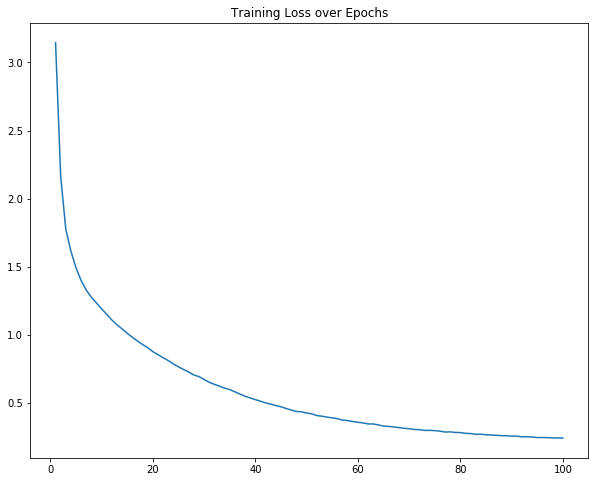

In [15]:
#plotting training loss over epochs
plt.figure(figsize=(10, 8))
plt.plot(df['epoch'], df['loss'])
plt.title('Training Loss over Epochs')
plt.show()

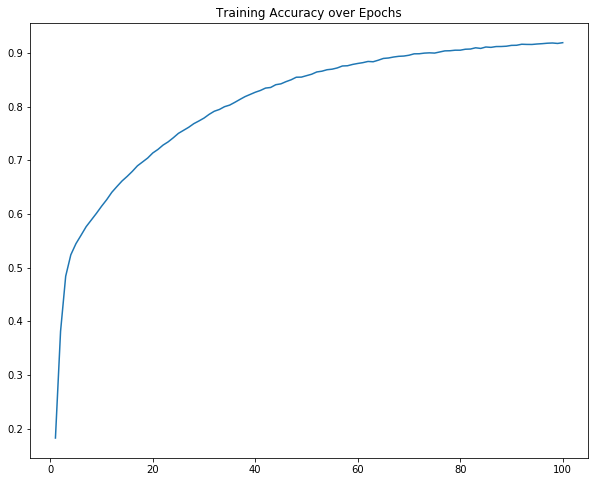

In [16]:
#plotting training accuracy over epochs
plt.figure(figsize=(10, 8))
plt.plot(df['epoch'], df['acc'])
plt.title('Training Accuracy over Epochs')
plt.show()

In [9]:
def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

In [10]:
def sample(epoch, header, num_chars):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_idx = json.load(f)
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    model = build_sample_model(vocab_size)
    load_weights(epoch, model)
    model.save(os.path.join(MODEL_DIR, 'model.{}.h5'.format(epoch)))

    sampled = [char_to_idx[c] for c in header]
    print(sampled)
    

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)

    return ''.join(idx_to_char[c] for c in sampled)

In [11]:
print(sample(100, '', 512))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[]
D"FAA "G"BAG|"D"F3 "G"G3:|


X: 173
T:Johny The Bous
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
A|"D"DFA d2d|"A"e2A ABc|"D"dcd "Em"edc|"A7"BcA "D"d2A|
"G"B2G "D7"c2A|"G"BAG "C"E2G|"A7"ABc "D"def|"Em"g2f "A7"edc|
"D"dAF D2D|"G"B2A B2c|"G"d3 "A7"Adc|"D"d3 "A7"a2g|
"D"f2d f2a|"D"a2f def|"Em"g2e "A7"Ace|"D"fdf agf|"D"edA F2A|
"D"DFA d2A|"G"BAB "D"def|"G"g2f "Em"deg|"D"fed "G"BAB|
"D"ABA AFA|"D"dcd "G"BdB|"D"A2A "Bm"AGF|"Em"E2E "A7"EFG|
"D"A3 f2e|"D"dcd "A"ABA|"G"Bcd "A7"efg|"D"fed d2::
f|"D"abf
